# Predicting Customer Propensity to Engage

##1. Installing and Importing Libraries

In [ ]:
!pip install lightgbm
!pip install datetime
!pip install plotly
!pip install more_itertools
!pip install imblearn
!pip install fast_ml
!pip install streamlit
!npm install -g localtunnel

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.1/52.1 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 246.1/246.1 kB 7.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.1/42.1 kB 2.0 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 54.3 MB/s

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from fast_ml.utilities import display_all
from fast_ml import eda
from plotly.offline import init_notebook_mode, iplot
from plotly import tools
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.colors import n_colors
from plotly.subplots import make_subplots
import datetime as dt
from scipy import stats
from more_itertools import unique_everseen
from sklearn.covariance import EllipticEnvelope
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split as tts
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
#import evalml
#from evalml import AutoMLSearch
import pickle

##2. Data Loading & Analysis

In [ ]:
orders_df = pd.read_csv('olist_orders_dataset.csv', engine='python')
order_items = pd.read_csv('olist_order_items_dataset.csv', engine='python')
order_reviews = pd.read_csv('olist_order_reviews_dataset.csv', engine='python')
products = pd.read_csv('olist_products_dataset.csv', engine='python')
product_category = pd.read_csv('product_category_name_translation.csv', engine='python')
customer = pd.read_csv('olist_customers_dataset.csv', engine='python')
payments = pd.read_csv('olist_order_payments_dataset.csv', engine='python')
sellers = pd.read_csv('olist_sellers_dataset.csv', engine='python')

In [ ]:
orders_df

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00
...,...,...,...,...,...,...,...,...
99436,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,delivered,2017-03-09 09:54:05,2017-03-09 09:54:05,2017-03-10 11:18:03,2017-03-17 15:08:01,2017-03-28 00:00:00
99437,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02 00:00:00
99438,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27 00:00:00
99439,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15 00:00:00


In [ ]:
order_items.head(10)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14
5,00048cc3ae777c65dbb7d2a0634bc1ea,1,ef92defde845ab8450f9d70c526ef70f,6426d21aca402a131fc0a5d0960a3c90,2017-05-23 03:55:27,21.90,12.69
6,00054e8431b9d7675808bcb819fb4a32,1,8d4f2bb7e93e6710a28f34fa83ee7d28,7040e82f899a04d1b434b795a43b4617,2017-12-14 12:10:31,19.90,11.85
7,000576fe39319847cbb9d288c5617fa6,1,557d850972a7d6f792fd18ae1400d9b6,5996cddab893a4652a15592fb58ab8db,2018-07-10 12:30:45,810.00,70.75
8,0005a1a1728c9d785b8e2b08b904576c,1,310ae3c140ff94b03219ad0adc3c778f,a416b6a846a11724393025641d4edd5e,2018-03-26 18:31:29,145.95,11.65
9,0005f50442cb953dcd1d21e1fb923495,1,4535b0e1091c278dfd193e5a1d63b39f,ba143b05f0110f0dc71ad71b4466ce92,2018-07-06 14:10:56,53.99,11.40


In [ ]:
order_reviews.head(10)

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53
5,15197aa66ff4d0650b5434f1b46cda19,b18dcdf73be66366873cd26c5724d1dc,1,NaN,NaN,2018-04-13 00:00:00,2018-04-16 00:39:37
6,07f9bee5d1b850860defd761afa7ff16,e48aa0d2dcec3a2e87348811bcfdf22b,5,NaN,NaN,2017-07-16 00:00:00,2017-07-18 19:30:34
7,7c6400515c67679fbee952a7525281ef,c31a859e34e3adac22f376954e19b39d,5,NaN,NaN,2018-08-14 00:00:00,2018-08-14 21:36:06
8,a3f6f7f6f433de0aefbb97da197c554c,9c214ac970e84273583ab523dfafd09b,5,NaN,NaN,2017-05-17 00:00:00,2017-05-18 12:05:37
9,8670d52e15e00043ae7de4c01cc2fe06,b9bf720beb4ab3728760088589c62129,4,recomendo,aparelho eficiente. no site a marca do aparelh...,2018-05-22 00:00:00,2018-05-23 16:45:47


In [ ]:
products.head(10)

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0
5,41d3672d4792049fa1779bb35283ed13,instrumentos_musicais,60.0,745.0,1.0,200.0,38.0,5.0,11.0
6,732bd381ad09e530fe0a5f457d81becb,cool_stuff,56.0,1272.0,4.0,18350.0,70.0,24.0,44.0
7,2548af3e6e77a690cf3eb6368e9ab61e,moveis_decoracao,56.0,184.0,2.0,900.0,40.0,8.0,40.0
8,37cc742be07708b53a98702e77a21a02,eletrodomesticos,57.0,163.0,1.0,400.0,27.0,13.0,17.0
9,8c92109888e8cdf9d66dc7e463025574,brinquedos,36.0,1156.0,1.0,600.0,17.0,10.0,12.0


In [ ]:
products.dtypes

product_id                     object
product_category_name          object
product_name_lenght           float64
product_description_lenght    float64
product_photos_qty            float64
product_weight_g              float64
product_length_cm             float64
product_height_cm             float64
product_width_cm              float64
dtype: object

In [ ]:
product_category.head(10)

,product_category_name,product_category_name_english
0,beleza_saude,health_beauty
1,informatica_acessorios,computers_accessories
2,automotivo,auto
3,cama_mesa_banho,bed_bath_table
4,moveis_decoracao,furniture_decor
5,esporte_lazer,sports_leisure
6,perfumaria,perfumery
7,utilidades_domesticas,housewares
8,telefonia,telephony
9,relogios_presentes,watches_gifts


In [ ]:
product_category.dtypes

product_category_name            object
product_category_name_english    object
dtype: object

In [ ]:
customer.head(10)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP
5,879864dab9bc3047522c92c82e1212b8,4c93744516667ad3b8f1fb645a3116a4,89254,jaragua do sul,SC
6,fd826e7cf63160e536e0908c76c3f441,addec96d2e059c80c30fe6871d30d177,4534,sao paulo,SP
7,5e274e7a0c3809e14aba7ad5aae0d407,57b2a98a409812fe9618067b6b8ebe4f,35182,timoteo,MG
8,5adf08e34b2e993982a47070956c5c65,1175e95fb47ddff9de6b2b06188f7e0d,81560,curitiba,PR
9,4b7139f34592b3a31687243a302fa75b,9afe194fb833f79e300e37e580171f22,30575,belo horizonte,MG


In [ ]:
payments.head(10)

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45
5,298fcdf1f73eb413e4d26d01b25bc1cd,1,credit_card,2,96.12
6,771ee386b001f06208a7419e4fc1bbd7,1,credit_card,1,81.16
7,3d7239c394a212faae122962df514ac7,1,credit_card,3,51.84
8,1f78449c87a54faf9e96e88ba1491fa9,1,credit_card,6,341.09
9,0573b5e23cbd798006520e1d5b4c6714,1,boleto,1,51.95


In [ ]:
categories = products.merge(product_category, on = 'product_category_name', how = 'left')

In [ ]:
categories

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0,perfumery
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0,art
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0,sports_leisure
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0,baby
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0,housewares
...,...,...,...,...,...,...,...,...,...,...
32946,a0b7d5a992ccda646f2d34e418fff5a0,moveis_decoracao,45.0,67.0,2.0,12300.0,40.0,40.0,40.0,furniture_decor
32947,bf4538d88321d0fd4412a93c974510e6,construcao_ferramentas_iluminacao,41.0,971.0,1.0,1700.0,16.0,19.0,16.0,construction_tools_lights
32948,9a7c6041fa9592d9d9ef6cfe62a71f8c,cama_mesa_banho,50.0,799.0,1.0,1400.0,27.0,7.0,27.0,bed_bath_table
32949,83808703fc0706a22e264b9d75f04a2e,informatica_acessorios,60.0,156.0,2.0,700.0,31.0,13.0,20.0,computers_accessories


In [ ]:
sellers.head(10)

,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP
2,ce3ad9de960102d0677a81f5d0bb7b2d,20031,rio de janeiro,RJ
3,c0f3eea2e14555b6faeea3dd58c1b1c3,4195,sao paulo,SP
4,51a04a8a6bdcb23deccc82b0b80742cf,12914,braganca paulista,SP
5,c240c4061717ac1806ae6ee72be3533b,20920,rio de janeiro,RJ
6,e49c26c3edfa46d227d5121a6b6e4d37,55325,brejao,PE
7,1b938a7ec6ac5061a66a3766e0e75f90,16304,penapolis,SP
8,768a86e36ad6aae3d03ee3c6433d61df,1529,sao paulo,SP
9,ccc4bbb5f32a6ab2b7066a4130f114e3,80310,curitiba,PR


In [ ]:
orders = orders_df.merge(customer, on="customer_id")
orders = orders.merge(order_items, on="order_id")
orders = orders.merge(products, on="product_id")
orders = orders.merge(product_category, on="product_category_name")
orders = orders.merge(payments, on="order_id")
orders = orders.merge(sellers, on="seller_id")
orders = orders.merge(order_reviews, on="order_id")

In [ ]:
orders.head(10)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,...,payment_value,seller_zip_code_prefix,seller_city,seller_state,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,3149,...,18.12,9350,maua,SP,a54f0611adc9ed256b57ede6b6eb5114,4,NaN,"Não testei o produto ainda, mas ele veio corre...",2017-10-11 00:00:00,2017-10-12 03:43:48
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,3149,...,2.00,9350,maua,SP,a54f0611adc9ed256b57ede6b6eb5114,4,NaN,"Não testei o produto ainda, mas ele veio corre...",2017-10-11 00:00:00,2017-10-12 03:43:48
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,3149,...,18.59,9350,maua,SP,a54f0611adc9ed256b57ede6b6eb5114,4,NaN,"Não testei o produto ainda, mas ele veio corre...",2017-10-11 00:00:00,2017-10-12 03:43:48
3,128e10d95713541c87cd1a2e48201934,a20e8105f23924cd00833fd87daa0831,delivered,2017-08-15 18:29:31,2017-08-15 20:05:16,2017-08-17 15:28:33,2017-08-18 14:44:43,2017-08-28 00:00:00,3a51803cc0d012c3b5dc8b7528cb05f7,3366,...,37.77,9350,maua,SP,b46f1e34512b0f4c74a72398b03ca788,4,NaN,Deveriam embalar melhor o produto. A caixa vei...,2017-08-19 00:00:00,2017-08-20 15:16:36
4,0e7e841ddf8f8f2de2bad69267ecfbcf,26c7ac168e1433912a51b924fbd34d34,delivered,2017-08-02 18:24:47,2017-08-02 18:43:15,2017-08-04 17:35:43,2017-08-07 18:30:01,2017-08-15 00:00:00,ef0996a1a279c26e7ecbd737be23d235,2290,...,37.77,9350,maua,SP,dc90f19c2806f1abba9e72ad3c350073,5,NaN,"Só achei ela pequena pra seis xícaras ,mais é ...",2017-08-08 00:00:00,2017-08-08 23:26:23
5,bfc39df4f36c3693ff3b63fcbea9e90a,53904ddbea91e1e92b2b3f1d09a7af86,delivered,2017-10-23 23:26:46,2017-10-25 02:14:11,2017-10-27 16:48:46,2017-11-07 18:04:59,2017-11-13 00:00:00,e781fdcc107d13d865fc7698711cc572,88032,...,44.09,9350,maua,SP,1bafb430e498b939f258b9c9dbdff9b1,3,NaN,NaN,2017-11-08 00:00:00,2017-11-10 19:52:38
6,5f49f31e537f8f1a496454b48edbe34d,a7260a6ccba78544ccfaf43f920b7240,delivered,2017-08-24 11:31:28,2017-08-24 11:45:25,2017-08-25 14:17:55,2017-08-28 20:12:20,2017-09-14 00:00:00,7a1de9bde89aedca8c5fbad489c5571c,1315,...,127.45,9350,maua,SP,8899ca945efd951c97107b4966289227,1,NaN,Prezados que porcaria de atendimento ao client...,2017-08-29 00:00:00,2017-08-30 02:26:02
7,5f49f31e537f8f1a496454b48edbe34d,a7260a6ccba78544ccfaf43f920b7240,delivered,2017-08-24 11:31:28,2017-08-24 11:45:25,2017-08-25 14:17:55,2017-08-28 20:12:20,2017-09-14 00:00:00,7a1de9bde89aedca8c5fbad489c5571c,1315,...,127.45,14021,ribeirao preto,SP,8899ca945efd951c97107b4966289227,1,NaN,Prezados que porcaria de atendimento ao client...,2017-08-29 00:00:00,2017-08-30 02:26:02
8,1fa40f202d5d233b6491e976c557b822,50fd5707c28d0a64dc20d67f937dd9ba,delivered,2017-09-23 22:11:10,2017-09-23 22:25:11,2017-09-26 17:27:54,2017-10-19 21:09:21,2017-11-13 00:00:00,35c6ec4630637b3ec0da6e587f245f83,69043,...,50.05,9350,maua,SP,4b70092fc12f2328972d5ff1022d87e9,4,NaN,NaN,2017-10-20 00:00:00,2017-10-23 04:13:41
9,41c045db2d1876be9f05cf4a787693b2,a286f46d6e54cc0179bbb0ee07b0df5e,delivered,2017-08-16 14:06:30,2017-08-16 14:55:20,2017-08-18 15:41:40,2017-08-21 15:05:13,2017-08-29 00:00:00,4e4fa2b85379e9db6dc59f873f0a9748,5640,...,32.68,9350,maua,SP,b9e086024ceb0234e5950016497a4928,5,NaN,NaN,2017-08-22 00:00:00,2017-08-26 02:31:53


In [ ]:
orders.shape

(115609, 40)

In [ ]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 115609 entries, 0 to 115608
Data columns (total 40 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_id                       115609 non-null  object 
 1   customer_id                    115609 non-null  object 
 2   order_status                   115609 non-null  object 
 3   order_purchase_timestamp       115609 non-null  object 
 4   order_approved_at              115595 non-null  object 
 5   order_delivered_carrier_date   114414 non-null  object 
 6   order_delivered_customer_date  113209 non-null  object 
 7   order_estimated_delivery_date  115609 non-null  object 
 8   customer_unique_id             115609 non-null  object 
 9   customer_zip_code_prefix       115609 non-null  int64  
 10  customer_city                  115609 non-null  object 
 11  customer_state                 115609 non-null  object 
 12  order_item_id                 

In [ ]:
sum(orders.duplicated())

0

In [ ]:
orders.describe()

,customer_zip_code_prefix,order_item_id,price,freight_value,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,payment_sequential,payment_installments,payment_value,seller_zip_code_prefix,review_score
count,115609.000000,115609.000000,115609.000000,115609.000000,115609.000000,115609.000000,115609.000000,115608.000000,115608.000000,115608.000000,115608.000000,115609.000000,115609.000000,115609.000000,115609.000000,115609.000000
mean,35061.537597,1.194535,120.619850,20.056880,48.766541,785.808198,2.205373,2113.907697,30.307903,16.638477,23.113167,1.093747,2.946233,172.387379,24515.713958,4.034409
std,29841.671732,0.685926,182.653476,15.836184,10.034187,652.418619,1.717771,3781.754895,16.211108,13.473570,11.755083,0.729849,2.781087,265.873969,27636.640968,1.385584
min,1003.000000,1.000000,0.850000,0.000000,5.000000,4.000000,1.000000,0.000000,7.000000,2.000000,6.000000,1.000000,0.000000,0.000000,1001.000000,1.000000
25%,11310.000000,1.000000,39.900000,13.080000,42.000000,346.000000,1.000000,300.000000,18.000000,8.000000,15.000000,1.000000,1.000000,60.870000,6429.000000,4.000000
50%,24241.000000,1.000000,74.900000,16.320000,52.000000,600.000000,1.000000,700.000000,25.000000,13.000000,20.000000,1.000000,2.000000,108.050000,13660.000000,5.000000
75%,58745.000000,1.000000,134.900000,21.210000,57.000000,983.000000,3.000000,1800.000000,38.000000,20.000000,30.000000,1.000000,4.000000,189.480000,28605.000000,5.000000
max,99980.000000,21.000000,6735.000000,409.680000,76.000000,3992.000000,20.000000,40425.000000,105.000000,105.000000,118.000000,29.000000,24.000000,13664.080000,99730.000000,5.000000


In [ ]:
orders.isnull().sum()

order_id                              0
customer_id                           0
order_status                          0
order_purchase_timestamp              0
order_approved_at                    14
order_delivered_carrier_date       1195
order_delivered_customer_date      2400
order_estimated_delivery_date         0
customer_unique_id                    0
customer_zip_code_prefix              0
customer_city                         0
customer_state                        0
order_item_id                         0
product_id                            0
seller_id                             0
shipping_limit_date                   0
price                                 0
freight_value                         0
product_category_name                 0
product_name_lenght                   0
product_description_lenght            0
product_photos_qty                    0
product_weight_g                      1
product_length_cm                     1
product_height_cm                     1


In [ ]:
orders.isnull().sum() / orders.shape[0]

order_id                         0.000000
customer_id                      0.000000
order_status                     0.000000
order_purchase_timestamp         0.000000
order_approved_at                0.000121
order_delivered_carrier_date     0.010337
order_delivered_customer_date    0.020760
order_estimated_delivery_date    0.000000
customer_unique_id               0.000000
customer_zip_code_prefix         0.000000
customer_city                    0.000000
customer_state                   0.000000
order_item_id                    0.000000
product_id                       0.000000
seller_id                        0.000000
shipping_limit_date              0.000000
price                            0.000000
freight_value                    0.000000
product_category_name            0.000000
product_name_lenght              0.000000
product_description_lenght       0.000000
product_photos_qty               0.000000
product_weight_g                 0.000009
product_length_cm                0

In [ ]:
orders

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,...,payment_value,seller_zip_code_prefix,seller_city,seller_state,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,3149,...,18.12,9350,maua,SP,a54f0611adc9ed256b57ede6b6eb5114,4,NaN,"Não testei o produto ainda, mas ele veio corre...",2017-10-11 00:00:00,2017-10-12 03:43:48
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,3149,...,2.00,9350,maua,SP,a54f0611adc9ed256b57ede6b6eb5114,4,NaN,"Não testei o produto ainda, mas ele veio corre...",2017-10-11 00:00:00,2017-10-12 03:43:48
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,3149,...,18.59,9350,maua,SP,a54f0611adc9ed256b57ede6b6eb5114,4,NaN,"Não testei o produto ainda, mas ele veio corre...",2017-10-11 00:00:00,2017-10-12 03:43:48
3,128e10d95713541c87cd1a2e48201934,a20e8105f23924cd00833fd87daa0831,delivered,2017-08-15 18:29:31,2017-08-15 20:05:16,2017-08-17 15:28:33,2017-08-18 14:44:43,2017-08-28 00:00:00,3a51803cc0d012c3b5dc8b7528cb05f7,3366,...,37.77,9350,maua,SP,b46f1e34512b0f4c74a72398b03ca788,4,NaN,Deveriam embalar melhor o produto. A caixa vei...,2017-08-19 00:00:00,2017-08-20 15:16:36
4,0e7e841ddf8f8f2de2bad69267ecfbcf,26c7ac168e1433912a51b924fbd34d34,delivered,2017-08-02 18:24:47,2017-08-02 18:43:15,2017-08-04 17:35:43,2017-08-07 18:30:01,2017-08-15 00:00:00,ef0996a1a279c26e7ecbd737be23d235,2290,...,37.77,9350,maua,SP,dc90f19c2806f1abba9e72ad3c350073,5,NaN,"Só achei ela pequena pra seis xícaras ,mais é ...",2017-08-08 00:00:00,2017-08-08 23:26:23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115604,edcf1e1eeb52381be9388c90152be52d,ce2172509c4149d65212484eb761bc37,delivered,2018-08-21 11:29:05,2018-08-21 11:50:47,2018-08-21 15:37:00,2018-08-24 13:06:25,2018-09-06 00:00:00,c5da6424f1f5decedef8672a1a0103e1,88350,...,314.32,95910,lajeado,RS,a6a6d2f97b28e8aca22046635855fe63,5,Pedido entregue,Recebi em 3 dias muito rápido tudo perfeito pa...,2018-08-25 00:00:00,2018-08-27 16:43:30
115605,2c12150c742ae2fa48bc703964c16c5f,ab0cf72dfe0538a63a57d6905ccb7b57,delivered,2018-07-28 17:55:27,2018-07-29 18:30:31,2018-07-30 14:54:00,2018-08-03 17:46:46,2018-08-16 00:00:00,8c3c961a52bb5a0ffbce1d4e6d25cd67,35930,...,77.50,17201,jau,SP,6b7c670a784ae6d3f17ee1d4b28d197e,5,NaN,NaN,2018-08-04 00:00:00,2018-08-05 22:10:19
115606,9f7ba492c273ffac8f90a623b8eadd3b,c61336d6c835632048f973d2f2db598d,delivered,2018-08-23 12:31:37,2018-08-24 03:24:24,2018-08-24 15:14:00,2018-08-28 02:06:35,2018-09-03 00:00:00,428f4721a509be8c52de6ec2900ba918,12305,...,24.69,17201,jau,SP,24e88b5f641a6a3219ce7a730509d570,5,NaN,Excelente,2018-08-28 00:00:00,2018-08-31 00:26:10
115607,2ef4a11b6e24fdfbb43b92cb5f95edff,ee1cfdc92e449920e25d3ca4ab4da4f6,delivered,2018-07-23 18:35:14,2018-07-24 10:31:25,2018-07-24 14:37:00,2018-07-27 14:04:10,2018-08-06 00:00:00,8d80e477643ec569b24592ce3d9dfc4c,9951,...,84.63,17201,jau,SP,ad0de1dda4fa03e8efb68c481b31ebf8,3,A FOLHA NAO FRISA,"Um dos frisadores que comprei, especificamente...",2018-07-28 00:00:00,2018-08-03 01:58:42


In [ ]:
orders.isnull().sum()

order_id                              0
customer_id                           0
order_status                          0
order_purchase_timestamp              0
order_approved_at                    14
order_delivered_carrier_date       1195
order_delivered_customer_date      2400
order_estimated_delivery_date         0
customer_unique_id                    0
customer_zip_code_prefix              0
customer_city                         0
customer_state                        0
order_item_id                         0
product_id                            0
seller_id                             0
shipping_limit_date                   0
price                                 0
freight_value                         0
product_category_name                 0
product_name_lenght                   0
product_description_lenght            0
product_photos_qty                    0
product_weight_g                      1
product_length_cm                     1
product_height_cm                     1


In [ ]:
orders.isnull().sum()/orders.shape[0]

order_id                         0.000000
customer_id                      0.000000
order_status                     0.000000
order_purchase_timestamp         0.000000
order_approved_at                0.000121
order_delivered_carrier_date     0.010337
order_delivered_customer_date    0.020760
order_estimated_delivery_date    0.000000
customer_unique_id               0.000000
customer_zip_code_prefix         0.000000
customer_city                    0.000000
customer_state                   0.000000
order_item_id                    0.000000
product_id                       0.000000
seller_id                        0.000000
shipping_limit_date              0.000000
price                            0.000000
freight_value                    0.000000
product_category_name            0.000000
product_name_lenght              0.000000
product_description_lenght       0.000000
product_photos_qty               0.000000
product_weight_g                 0.000009
product_length_cm                0

In [ ]:
orders['order_purchase_timestamp'] = pd.to_datetime(orders.order_purchase_timestamp).dt.date
orders['order_approved_at'] = pd.to_datetime(orders.order_approved_at).dt.date
orders['order_estimated_delivery_date'] = pd.to_datetime(orders.order_estimated_delivery_date).dt.date
orders['order_delivered_customer_date'] = pd.to_datetime(orders.order_delivered_customer_date).dt.date
orders['review_answer_timestamp'] = pd.to_datetime(orders.review_answer_timestamp).dt.date
orders['review_creation_date'] = pd.to_datetime(orders.review_answer_timestamp).dt.date

In [ ]:
orders.head(10)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,...,payment_value,seller_zip_code_prefix,seller_city,seller_state,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02,2017-10-02,2017-10-04 19:55:00,2017-10-10,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,...,18.12,9350,maua,SP,a54f0611adc9ed256b57ede6b6eb5114,4,NaN,"Não testei o produto ainda, mas ele veio corre...",2017-10-12,2017-10-12
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02,2017-10-02,2017-10-04 19:55:00,2017-10-10,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,...,2.00,9350,maua,SP,a54f0611adc9ed256b57ede6b6eb5114,4,NaN,"Não testei o produto ainda, mas ele veio corre...",2017-10-12,2017-10-12
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02,2017-10-02,2017-10-04 19:55:00,2017-10-10,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,...,18.59,9350,maua,SP,a54f0611adc9ed256b57ede6b6eb5114,4,NaN,"Não testei o produto ainda, mas ele veio corre...",2017-10-12,2017-10-12
3,128e10d95713541c87cd1a2e48201934,a20e8105f23924cd00833fd87daa0831,delivered,2017-08-15,2017-08-15,2017-08-17 15:28:33,2017-08-18,2017-08-28,3a51803cc0d012c3b5dc8b7528cb05f7,3366,...,37.77,9350,maua,SP,b46f1e34512b0f4c74a72398b03ca788,4,NaN,Deveriam embalar melhor o produto. A caixa vei...,2017-08-20,2017-08-20
4,0e7e841ddf8f8f2de2bad69267ecfbcf,26c7ac168e1433912a51b924fbd34d34,delivered,2017-08-02,2017-08-02,2017-08-04 17:35:43,2017-08-07,2017-08-15,ef0996a1a279c26e7ecbd737be23d235,2290,...,37.77,9350,maua,SP,dc90f19c2806f1abba9e72ad3c350073,5,NaN,"Só achei ela pequena pra seis xícaras ,mais é ...",2017-08-08,2017-08-08
5,bfc39df4f36c3693ff3b63fcbea9e90a,53904ddbea91e1e92b2b3f1d09a7af86,delivered,2017-10-23,2017-10-25,2017-10-27 16:48:46,2017-11-07,2017-11-13,e781fdcc107d13d865fc7698711cc572,88032,...,44.09,9350,maua,SP,1bafb430e498b939f258b9c9dbdff9b1,3,NaN,NaN,2017-11-10,2017-11-10
6,5f49f31e537f8f1a496454b48edbe34d,a7260a6ccba78544ccfaf43f920b7240,delivered,2017-08-24,2017-08-24,2017-08-25 14:17:55,2017-08-28,2017-09-14,7a1de9bde89aedca8c5fbad489c5571c,1315,...,127.45,9350,maua,SP,8899ca945efd951c97107b4966289227,1,NaN,Prezados que porcaria de atendimento ao client...,2017-08-30,2017-08-30
7,5f49f31e537f8f1a496454b48edbe34d,a7260a6ccba78544ccfaf43f920b7240,delivered,2017-08-24,2017-08-24,2017-08-25 14:17:55,2017-08-28,2017-09-14,7a1de9bde89aedca8c5fbad489c5571c,1315,...,127.45,14021,ribeirao preto,SP,8899ca945efd951c97107b4966289227,1,NaN,Prezados que porcaria de atendimento ao client...,2017-08-30,2017-08-30
8,1fa40f202d5d233b6491e976c557b822,50fd5707c28d0a64dc20d67f937dd9ba,delivered,2017-09-23,2017-09-23,2017-09-26 17:27:54,2017-10-19,2017-11-13,35c6ec4630637b3ec0da6e587f245f83,69043,...,50.05,9350,maua,SP,4b70092fc12f2328972d5ff1022d87e9,4,NaN,NaN,2017-10-23,2017-10-23
9,41c045db2d1876be9f05cf4a787693b2,a286f46d6e54cc0179bbb0ee07b0df5e,delivered,2017-08-16,2017-08-16,2017-08-18 15:41:40,2017-08-21,2017-08-29,4e4fa2b85379e9db6dc59f873f0a9748,5640,...,32.68,9350,maua,SP,b9e086024ceb0234e5950016497a4928,5,NaN,NaN,2017-08-26,2017-08-26


In [ ]:
orders.shape

(115609, 40)

In [ ]:
cont_columns = list(orders.select_dtypes(include=[np.number]).columns.values)
cat_columns = list(orders.select_dtypes(include=['object']).columns.values)

##3. Data Visualizations

In [ ]:
sns.set_theme(style = "darkgrid")

**1. Plot for customer_zip_code_prefix**

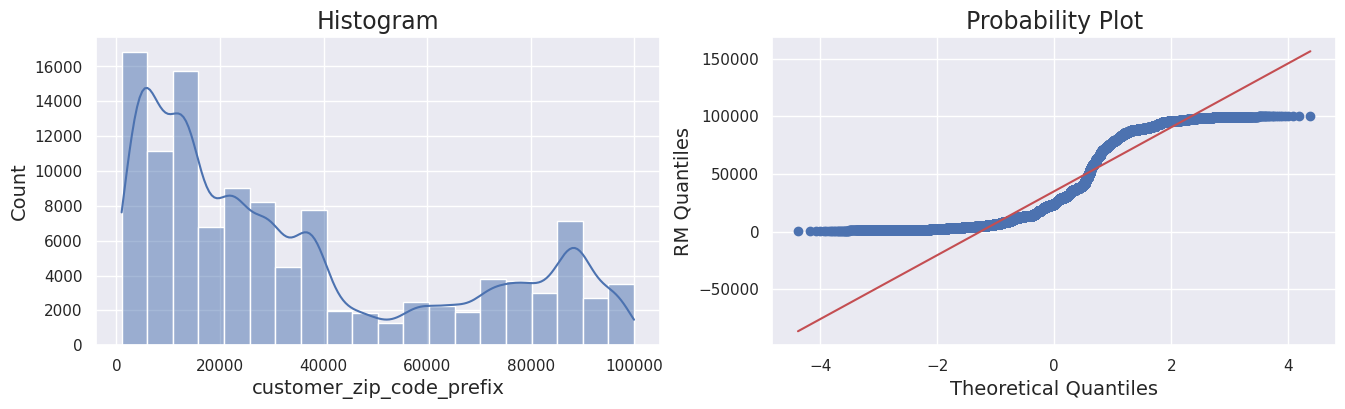

**2. Plot for order_item_id**

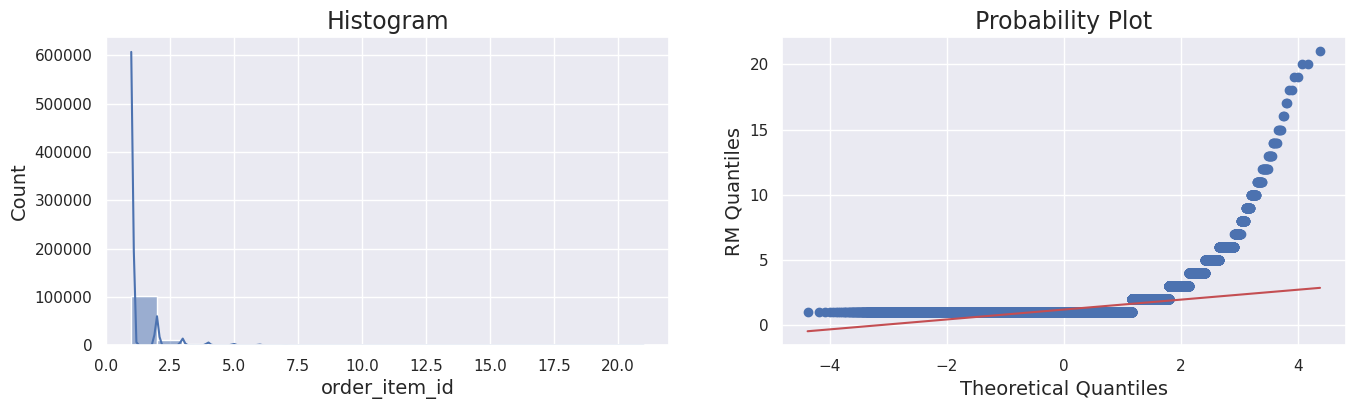

**3. Plot for price**

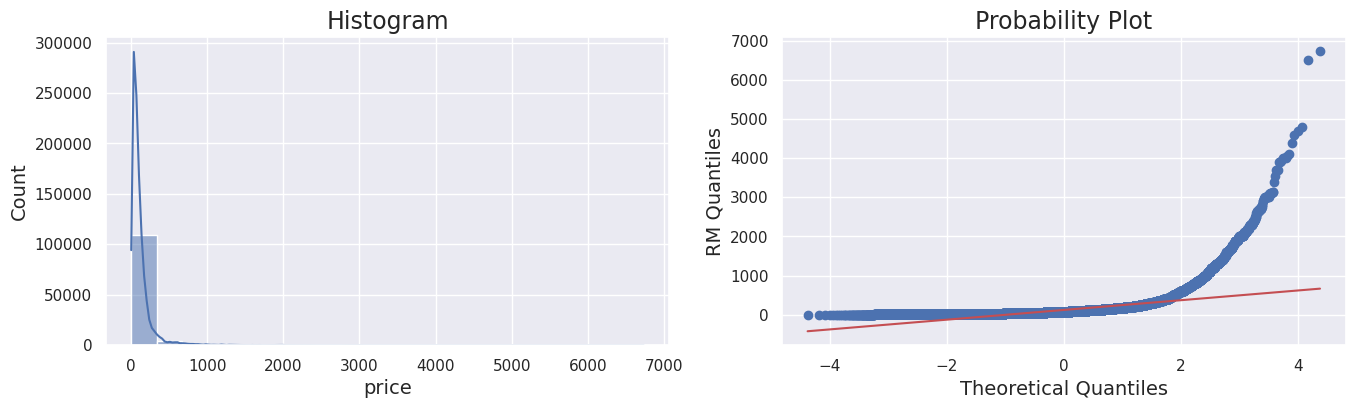

**4. Plot for freight_value**

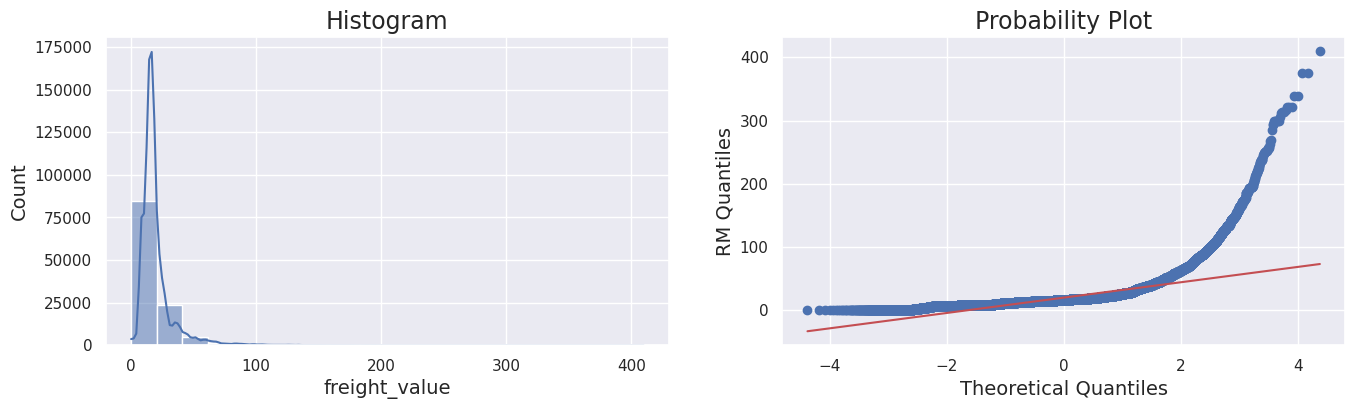

**5. Plot for product_name_lenght**

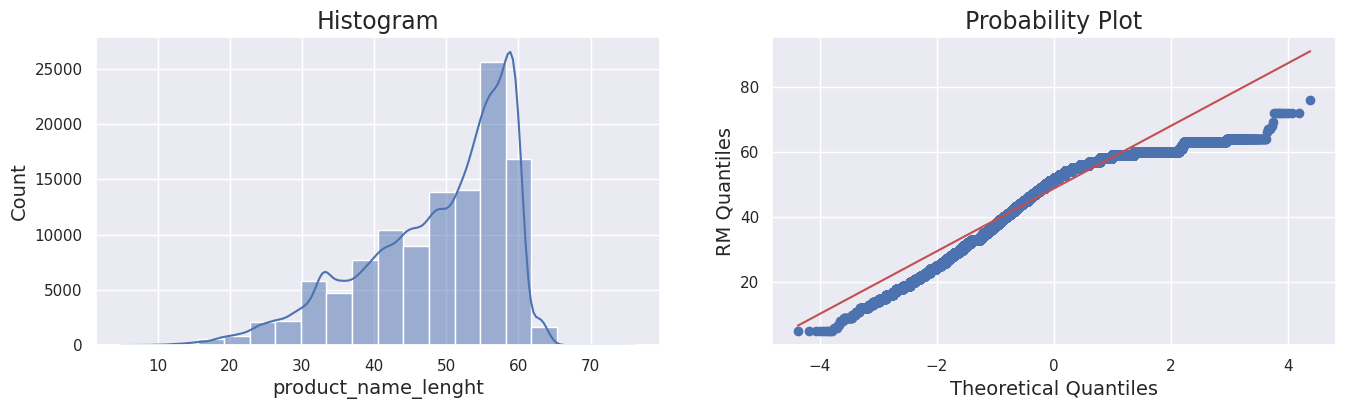

**6. Plot for product_description_lenght**

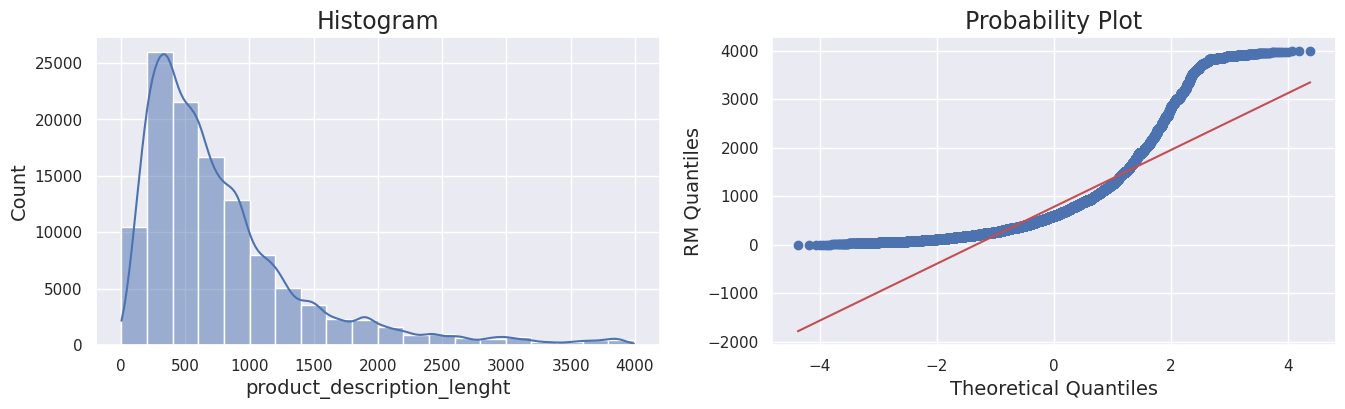

**7. Plot for product_photos_qty**

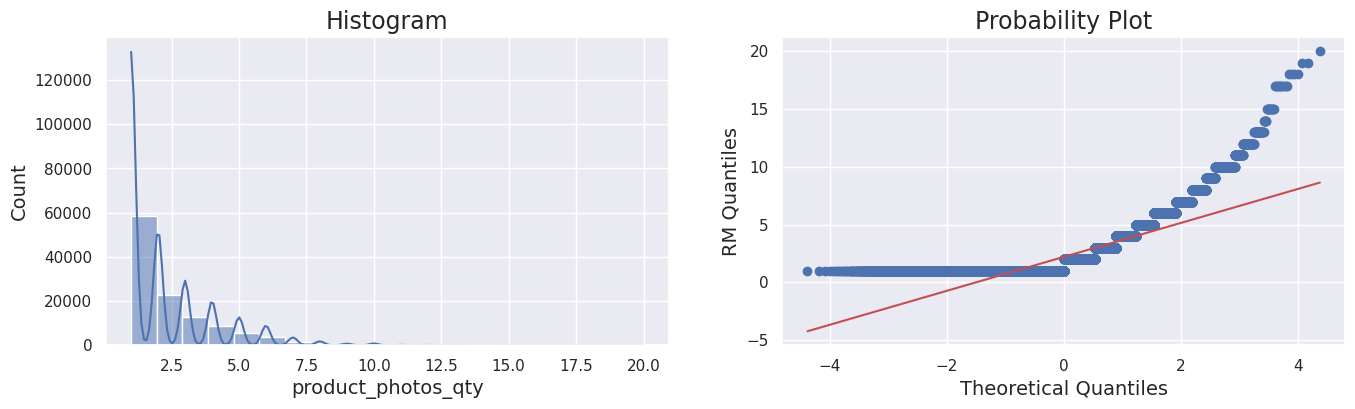

**8. Plot for product_weight_g**

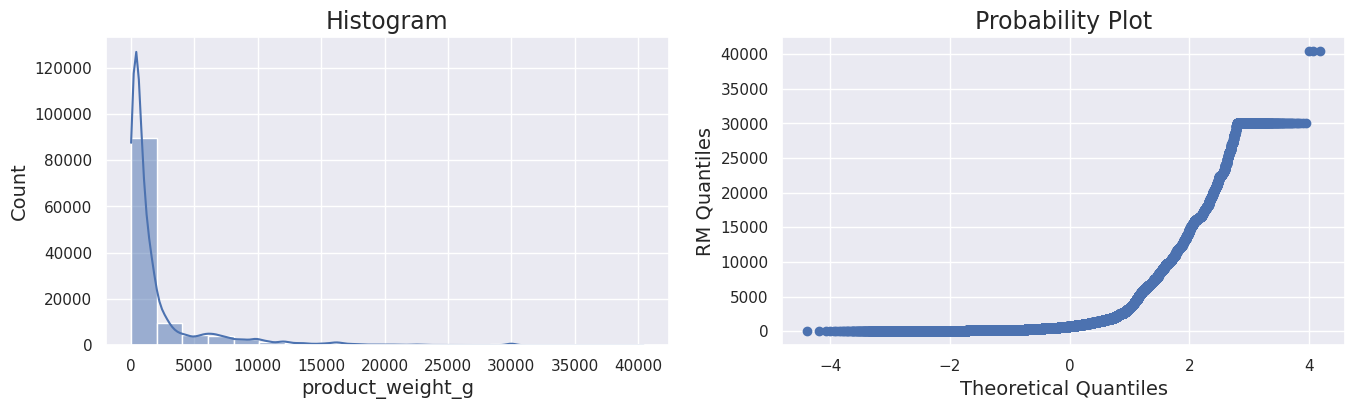

**9. Plot for product_length_cm**

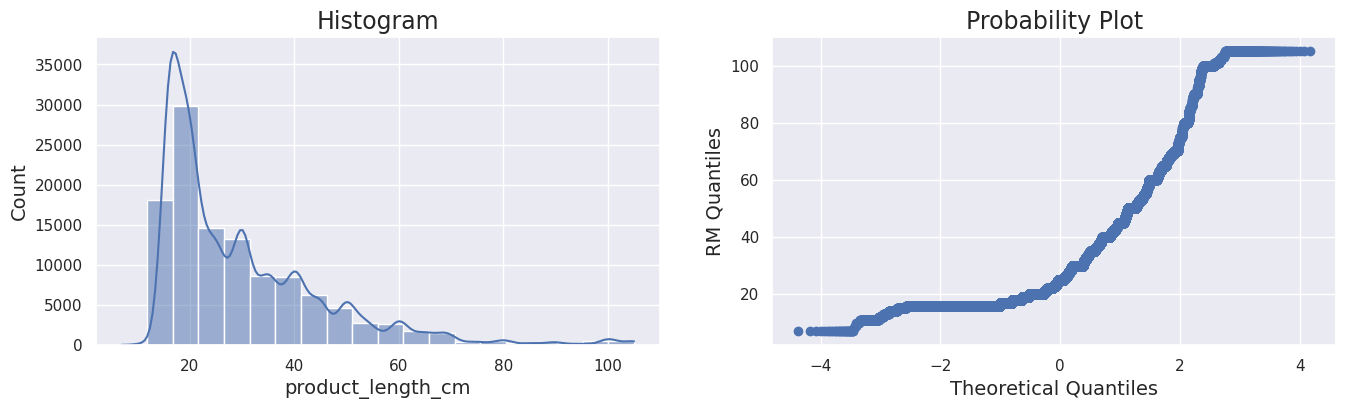

**10. Plot for product_height_cm**

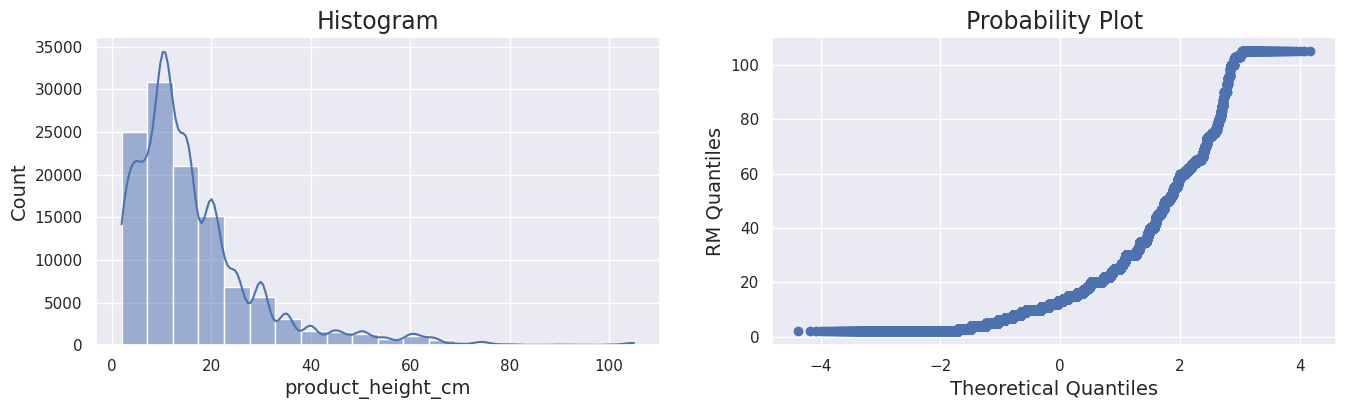

**11. Plot for product_width_cm**

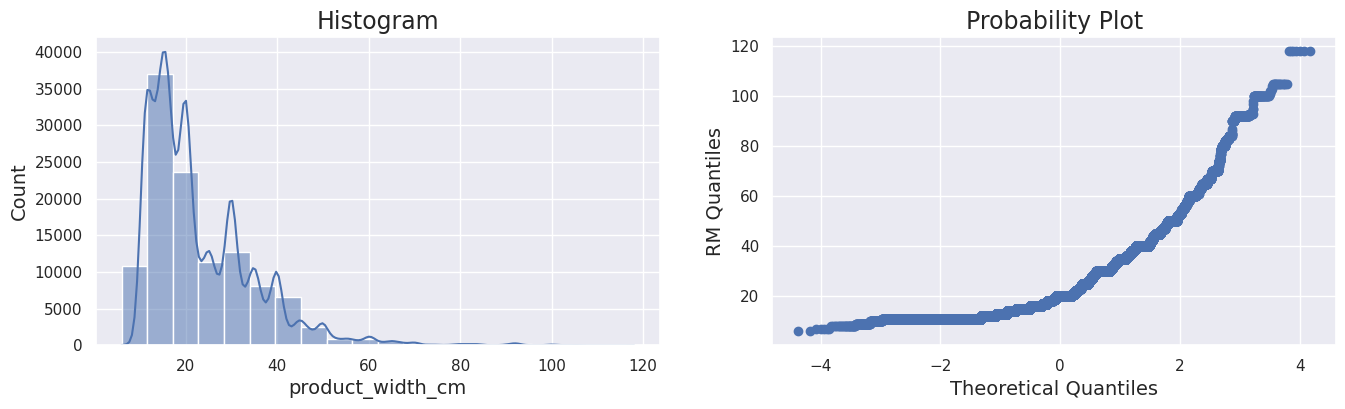

**12. Plot for payment_sequential**

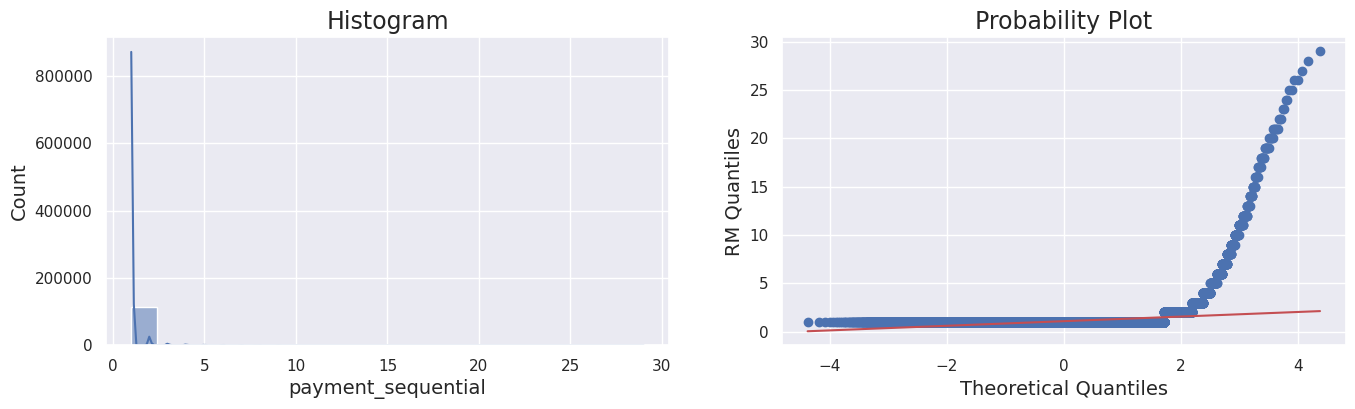

**13. Plot for payment_installments**

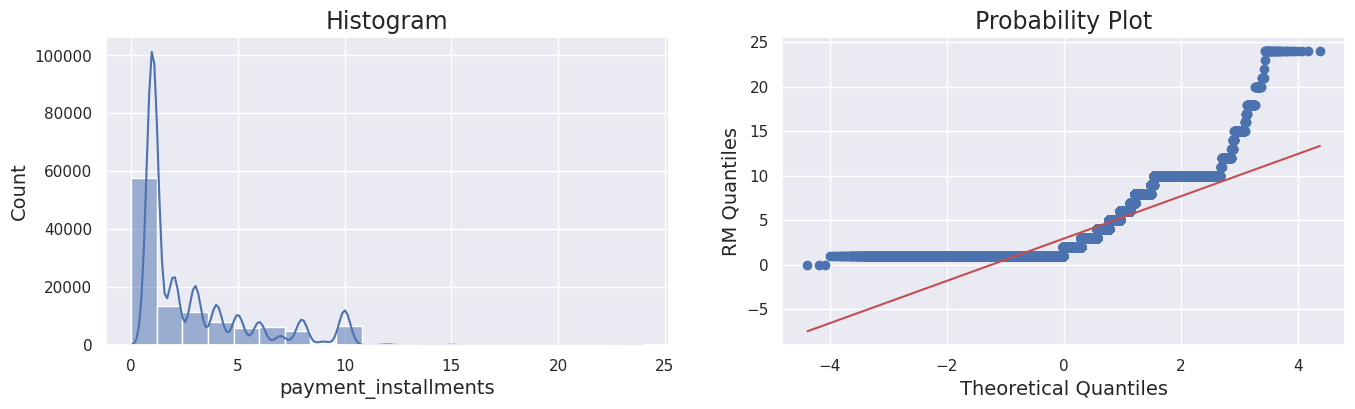

**14. Plot for payment_value**

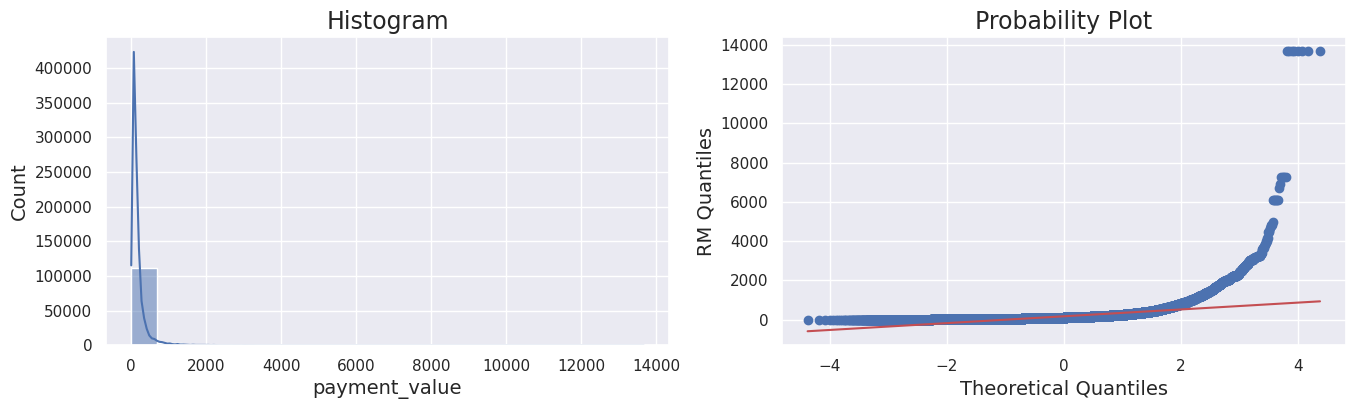

**15. Plot for seller_zip_code_prefix**

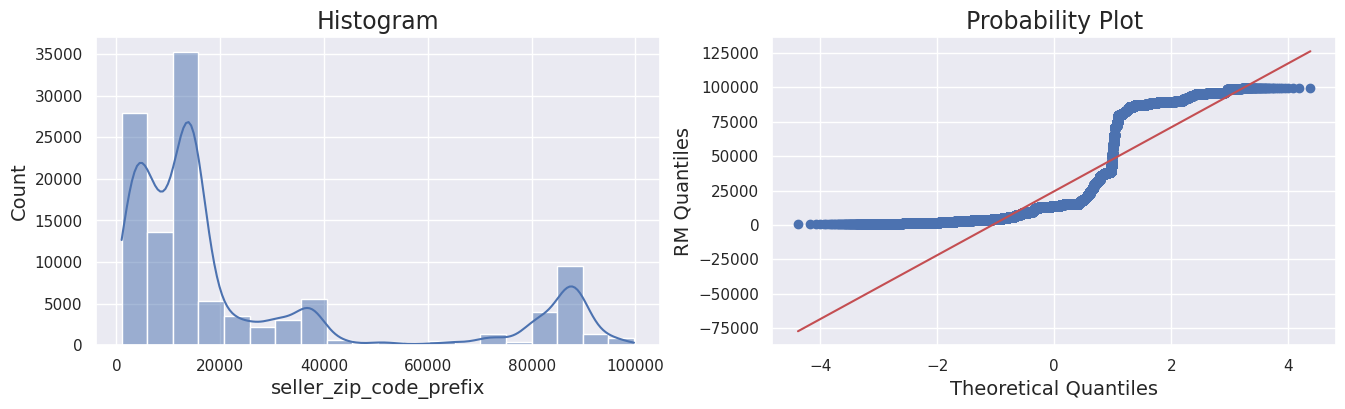

**16. Plot for review_score**

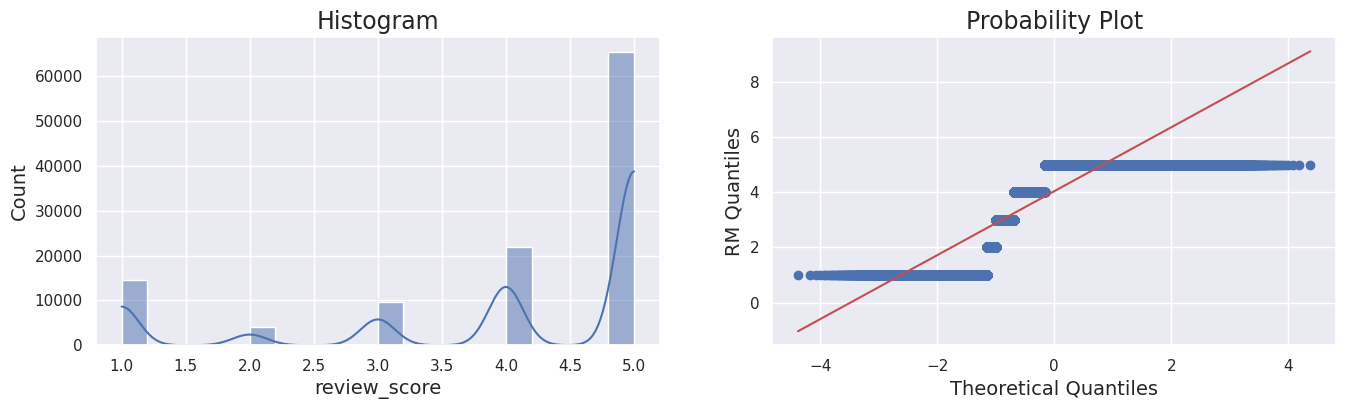

In [ ]:
eda.numerical_plots(orders, cont_columns, normality_check = True)

In [ ]:
fig = px.pie(orders['customer_state'], names = orders['customer_state'].value_counts().index,
             values = orders['customer_state'].value_counts().values,
             title = 'Customer State')
fig.show()

In [ ]:
fig = px.pie(orders['review_score'], names = orders['review_score'].value_counts().index,
             values = orders['review_score'].value_counts().values,
             title = 'Review Scores')
fig.show()

In [ ]:
items_reviews = pd.merge(order_reviews, order_items, how='left', on='order_id')
review_qty = items_reviews.groupby('review_score').size()
review_value = items_reviews.groupby('review_score')['price'].mean()

In [ ]:
trace0 = go.Bar(
    x=review_qty.index,
    y=review_qty.values,
    name='Number of orders',
    marker=dict(color='rgb(49,130,189)')
)
trace1 = go.Bar(
    x=review_value.index,
    y=review_value.values,
    name='Product mean value',
    marker=dict(color='rgb(204,204,204)')
)
fig = make_subplots(rows=1, cols=2, print_grid=False)
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)

fig['layout'].update(height=400, width=800, title='Review Score')
fig['layout']['xaxis1'].update(title='review score', domain=[0, 0.40], tickmode = 'linear')
fig['layout']['xaxis2'].update(title='review score', domain=[0.6, 1], tickmode = 'linear')
iplot(fig);

<ipython-input-37-664a6fac9793>:3: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



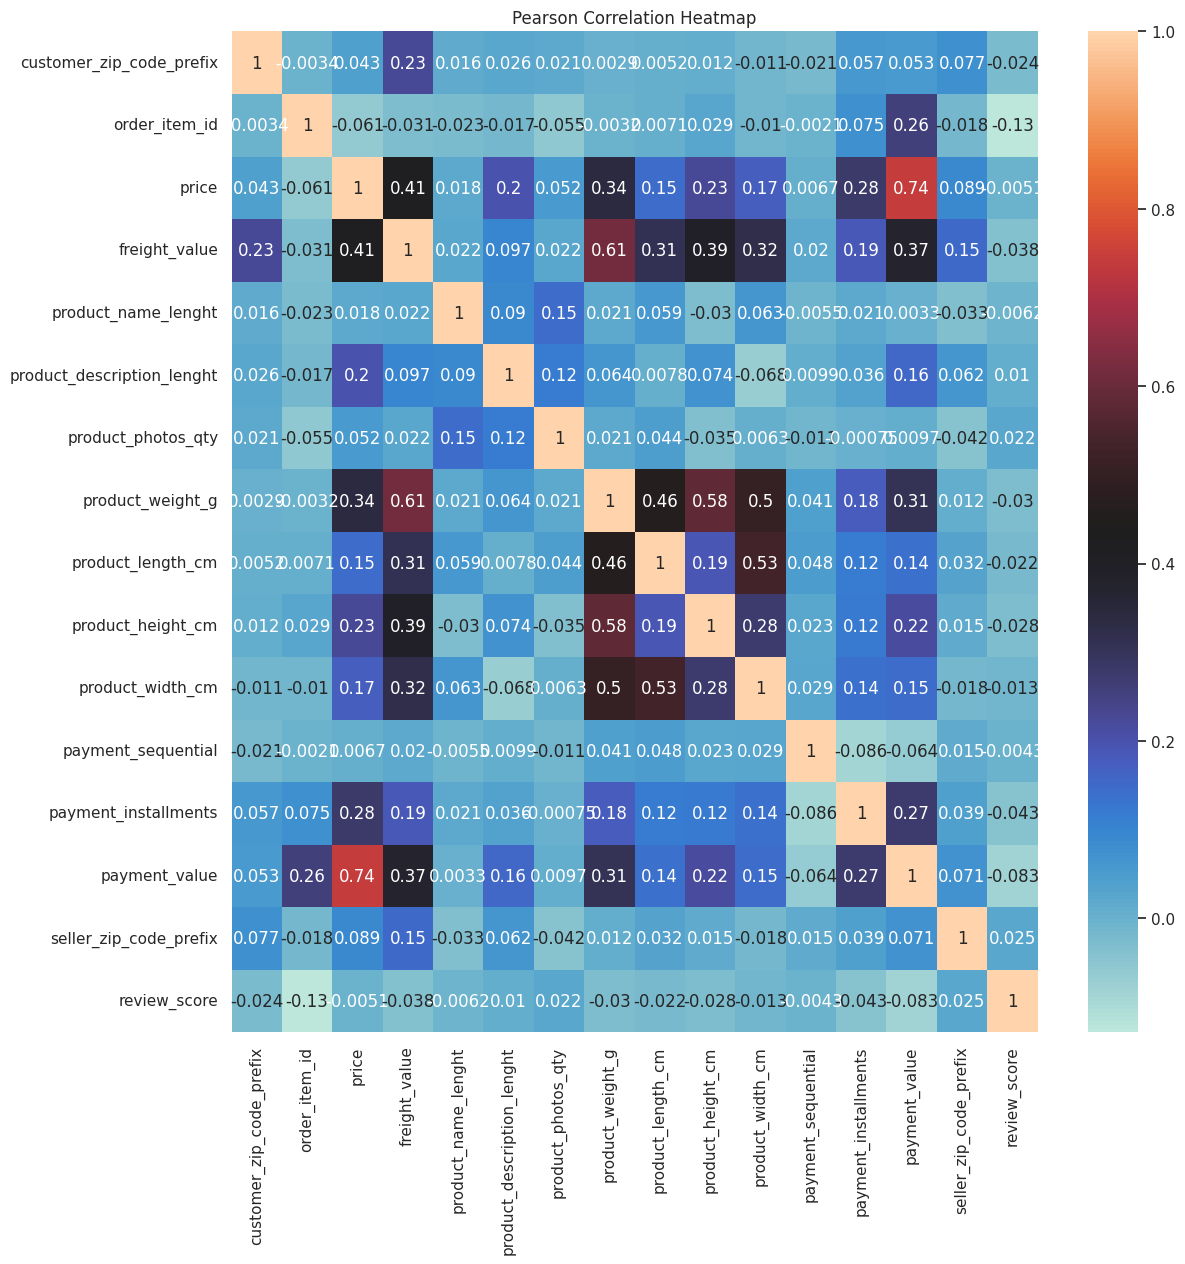

In [ ]:
fig, ax = plt.subplots(figsize = (13, 13))
plt.title("Pearson Correlation Heatmap")
sns.heatmap(orders.corr(method = 'pearson'), annot = True, cmap = 'icefire')
plt.show()

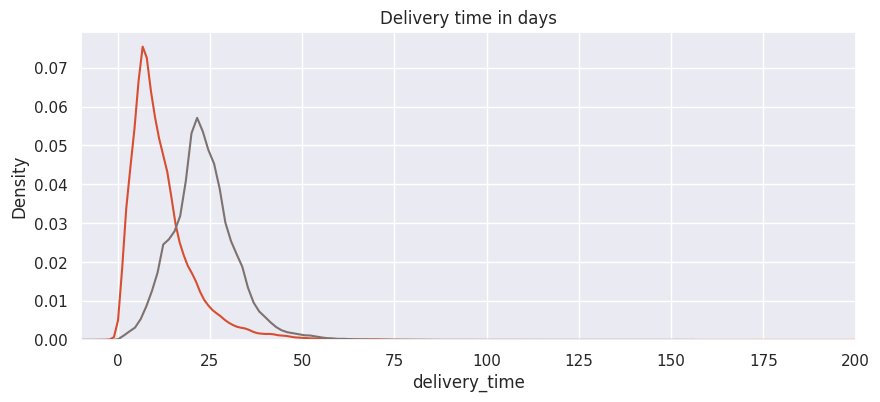

In [ ]:
orders_df['order_purchase_timestamp'] = pd.to_datetime(orders_df['order_purchase_timestamp'])
orders_df['order_approved_at'] = pd.to_datetime(orders_df['order_approved_at'])
orders_df['order_estimated_delivery_date'] = pd.to_datetime(orders_df['order_estimated_delivery_date'])
orders_df['order_delivered_customer_date'] = pd.to_datetime(orders_df['order_delivered_customer_date'])
orders_df['delivery_time'] = (orders_df['order_delivered_customer_date'] - orders_df['order_approved_at']).dt.total_seconds() / 86400
orders_df['estimated_delivery_time'] = (orders_df['order_estimated_delivery_date'] - orders_df['order_approved_at']).dt.total_seconds() / 86400
plt.figure(figsize=(10,4))
plt.title("Delivery time in days")
plt.xlim(-10, 200)

ax1 = sns.kdeplot(orders_df['delivery_time'].dropna(), color="#D84E30", label='Delivery time')
ax2 = sns.kdeplot(orders_df['estimated_delivery_time'].dropna(), color="#7E7270", label='Estimated delivery time')

In [ ]:
top_ordersbyvalue_cities = orders.groupby("customer_city")["payment_value"].sum().reset_index().sort_values("payment_value", ascending=False)
top_ordersbyvalue_cities["% of Total Payments"] = (top_ordersbyvalue_cities["payment_value"] / top_ordersbyvalue_cities["payment_value"].sum()) * 100
top_ordersbyvalue_cities["Cum % of Total Payments"] = top_ordersbyvalue_cities["% of Total Payments"].cumsum()

In [ ]:
fig = px.bar(top_ordersbyvalue_cities[:10], x = "% of Total Payments", y = "customer_city",
             title = "Highest 10 cities by revenue generation")
fig.update_layout(yaxis={'categoryorder':'total ascending'})
fig.show()

In [ ]:
fig = px.bar(top_ordersbyvalue_cities[-10:], x = "% of Total Payments", y = "customer_city",
             title = "Lowest 10 cities by revenue generation")
fig.show()

In [ ]:
plt.figure(figsize=(6,6))
reviewsocres = orders.groupby("product_category_name_english")["review_score"].agg(["mean", "count"]).sort_values(by="mean",ascending=False)
bestrated = reviewsocres[reviewsocres["count"]>=30][:10]
bestrated
fig = px.bar(bestrated, x = bestrated.values[0:, 0], y = bestrated.index,
             title = "Highest 10 rated items categories")
fig.update_layout(yaxis={'categoryorder':'total ascending'})
fig.show()

<Figure size 600x600 with 0 Axes>

In [ ]:
plt.figure(figsize=(6,6))
worstrated = reviewsocres[reviewsocres["count"]>=30].sort_values(by='mean')[:10]
fig = px.bar(worstrated, x = worstrated.values[0:, 0], y = worstrated.index,
             title = "Lowest 10 rated items categories")
fig.show()

<Figure size 600x600 with 0 Axes>

In [ ]:
merged_groups = orders.groupby('customer_city')['payment_value'].sum().reset_index().sort_values('payment_value', ascending = False)
plt.figure(figsize = (12, 12))
fig = px.bar(merged_groups[:10], x = "customer_city", y='payment_value', title = 'Payment Value on the basis of State')
fig.show()

<Figure size 1200x1200 with 0 Axes>

In [ ]:
merged_groups = orders.groupby('product_category_name_english')['payment_value'].sum().reset_index().sort_values('payment_value', ascending = False)
plt.figure(figsize = (15, 15))
fig = px.bar(merged_groups[:10], x = "product_category_name_english", y='payment_value', title = 'Payment Value on the basis Product Value')
fig.show()

<Figure size 1500x1500 with 0 Axes>

In [ ]:
scorevstime = orders.groupby(pd.to_datetime(orders.order_purchase_timestamp).dt.year)["review_score"].mean().dropna()
plt.figure(figsize=(6,6))
fig = px.bar(scorevstime, x = scorevstime.index , y = scorevstime.values,
             title = "Mean Review Score on Yearly Basis")
fig.show()

<Figure size 600x600 with 0 Axes>

## 4. Feature Enigneering 1

In [ ]:
orders.head(10)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,...,payment_value,seller_zip_code_prefix,seller_city,seller_state,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02,2017-10-02,2017-10-04 19:55:00,2017-10-10,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,...,18.12,9350,maua,SP,a54f0611adc9ed256b57ede6b6eb5114,4,NaN,"Não testei o produto ainda, mas ele veio corre...",2017-10-12,2017-10-12
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02,2017-10-02,2017-10-04 19:55:00,2017-10-10,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,...,2.00,9350,maua,SP,a54f0611adc9ed256b57ede6b6eb5114,4,NaN,"Não testei o produto ainda, mas ele veio corre...",2017-10-12,2017-10-12
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02,2017-10-02,2017-10-04 19:55:00,2017-10-10,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,...,18.59,9350,maua,SP,a54f0611adc9ed256b57ede6b6eb5114,4,NaN,"Não testei o produto ainda, mas ele veio corre...",2017-10-12,2017-10-12
3,128e10d95713541c87cd1a2e48201934,a20e8105f23924cd00833fd87daa0831,delivered,2017-08-15,2017-08-15,2017-08-17 15:28:33,2017-08-18,2017-08-28,3a51803cc0d012c3b5dc8b7528cb05f7,3366,...,37.77,9350,maua,SP,b46f1e34512b0f4c74a72398b03ca788,4,NaN,Deveriam embalar melhor o produto. A caixa vei...,2017-08-20,2017-08-20
4,0e7e841ddf8f8f2de2bad69267ecfbcf,26c7ac168e1433912a51b924fbd34d34,delivered,2017-08-02,2017-08-02,2017-08-04 17:35:43,2017-08-07,2017-08-15,ef0996a1a279c26e7ecbd737be23d235,2290,...,37.77,9350,maua,SP,dc90f19c2806f1abba9e72ad3c350073,5,NaN,"Só achei ela pequena pra seis xícaras ,mais é ...",2017-08-08,2017-08-08
5,bfc39df4f36c3693ff3b63fcbea9e90a,53904ddbea91e1e92b2b3f1d09a7af86,delivered,2017-10-23,2017-10-25,2017-10-27 16:48:46,2017-11-07,2017-11-13,e781fdcc107d13d865fc7698711cc572,88032,...,44.09,9350,maua,SP,1bafb430e498b939f258b9c9dbdff9b1,3,NaN,NaN,2017-11-10,2017-11-10
6,5f49f31e537f8f1a496454b48edbe34d,a7260a6ccba78544ccfaf43f920b7240,delivered,2017-08-24,2017-08-24,2017-08-25 14:17:55,2017-08-28,2017-09-14,7a1de9bde89aedca8c5fbad489c5571c,1315,...,127.45,9350,maua,SP,8899ca945efd951c97107b4966289227,1,NaN,Prezados que porcaria de atendimento ao client...,2017-08-30,2017-08-30
7,5f49f31e537f8f1a496454b48edbe34d,a7260a6ccba78544ccfaf43f920b7240,delivered,2017-08-24,2017-08-24,2017-08-25 14:17:55,2017-08-28,2017-09-14,7a1de9bde89aedca8c5fbad489c5571c,1315,...,127.45,14021,ribeirao preto,SP,8899ca945efd951c97107b4966289227,1,NaN,Prezados que porcaria de atendimento ao client...,2017-08-30,2017-08-30
8,1fa40f202d5d233b6491e976c557b822,50fd5707c28d0a64dc20d67f937dd9ba,delivered,2017-09-23,2017-09-23,2017-09-26 17:27:54,2017-10-19,2017-11-13,35c6ec4630637b3ec0da6e587f245f83,69043,...,50.05,9350,maua,SP,4b70092fc12f2328972d5ff1022d87e9,4,NaN,NaN,2017-10-23,2017-10-23
9,41c045db2d1876be9f05cf4a787693b2,a286f46d6e54cc0179bbb0ee07b0df5e,delivered,2017-08-16,2017-08-16,2017-08-18 15:41:40,2017-08-21,2017-08-29,4e4fa2b85379e9db6dc59f873f0a9748,5640,...,32.68,9350,maua,SP,b9e086024ceb0234e5950016497a4928,5,NaN,NaN,2017-08-26,2017-08-26


In [ ]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 115609 entries, 0 to 115608
Data columns (total 40 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_id                       115609 non-null  object 
 1   customer_id                    115609 non-null  object 
 2   order_status                   115609 non-null  object 
 3   order_purchase_timestamp       115609 non-null  object 
 4   order_approved_at              115595 non-null  object 
 5   order_delivered_carrier_date   114414 non-null  object 
 6   order_delivered_customer_date  113209 non-null  object 
 7   order_estimated_delivery_date  115609 non-null  object 
 8   customer_unique_id             115609 non-null  object 
 9   customer_zip_code_prefix       115609 non-null  int64  
 10  customer_city                  115609 non-null  object 
 11  customer_state                 115609 non-null  object 
 12  order_item_id                 

In [ ]:
recency = orders.groupby(by = 'customer_unique_id', as_index = False)['order_purchase_timestamp'].max()
recency.rename(columns = {"order_purchase_timestamp":"LastPurchaseDate"}, inplace=True)
recency["LastPurchaseDate"] =  pd.to_datetime(recency.LastPurchaseDate).dt.date

recent_date = pd.to_datetime(orders.order_purchase_timestamp).dt.date.max()
recency['Recency'] = recency['LastPurchaseDate'].apply(lambda x: (recent_date - x).days)

In [ ]:
recency

,customer_unique_id,LastPurchaseDate,Recency
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10,116
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07,119
2,0000f46a3911fa3c0805444483337064,2017-03-10,542
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-12,326
4,0004aac84e0df4da2b147fca70cf8255,2017-11-14,293
...,...,...,...
93391,fffcf5a5ff07b0908bd4e2dbc735a684,2017-06-08,452
93392,fffea47cd6d3cc0a88bd621562a9d061,2017-12-10,267
93393,ffff371b4d645b6ecea244b27531430a,2017-02-07,573
93394,ffff5962728ec6157033ef9805bacc48,2018-05-02,124


In [ ]:
frequency = orders.groupby(["customer_unique_id"]).agg({"order_id":"nunique"}).reset_index()
frequency.rename(columns={"order_id":"Frequency"}, inplace=True)

In [ ]:
frequency

,customer_unique_id,Frequency
0,0000366f3b9a7992bf8c76cfdf3221e2,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1
2,0000f46a3911fa3c0805444483337064,1
3,0000f6ccb0745a6a4b88665a16c9f078,1
4,0004aac84e0df4da2b147fca70cf8255,1
...,...,...
93391,fffcf5a5ff07b0908bd4e2dbc735a684,1
93392,fffea47cd6d3cc0a88bd621562a9d061,1
93393,ffff371b4d645b6ecea244b27531430a,1
93394,ffff5962728ec6157033ef9805bacc48,1


In [ ]:
monetary = orders.groupby('customer_unique_id', as_index=False)['payment_value'].sum()
monetary.columns = ['customer_unique_id', 'Monetary']

In [ ]:
monetary

,customer_unique_id,Monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,141.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,27.19
2,0000f46a3911fa3c0805444483337064,86.22
3,0000f6ccb0745a6a4b88665a16c9f078,43.62
4,0004aac84e0df4da2b147fca70cf8255,196.89
...,...,...
93391,fffcf5a5ff07b0908bd4e2dbc735a684,4134.84
93392,fffea47cd6d3cc0a88bd621562a9d061,84.58
93393,ffff371b4d645b6ecea244b27531430a,112.46
93394,ffff5962728ec6157033ef9805bacc48,133.69


In [ ]:
rf = recency.merge(frequency, on='customer_unique_id')
rfm = rf.merge(monetary, on='customer_unique_id').drop(columns='LastPurchaseDate')
rfm.head()

,customer_unique_id,Recency,Frequency,Monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,116,1,141.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,119,1,27.19
2,0000f46a3911fa3c0805444483337064,542,1,86.22
3,0000f6ccb0745a6a4b88665a16c9f078,326,1,43.62
4,0004aac84e0df4da2b147fca70cf8255,293,1,196.89


In [ ]:
rfm[rfm.columns[1:]] = rfm[rfm.columns[1:]].applymap(lambda x: 1 if x ==0 else x)

In [ ]:
def check_skew(df_skew, column):
    skew = stats.skew(df_skew[column])
    skewtest = stats.skewtest(df_skew[column])
    plt.title('Distribution of ' + column)
    sns.distplot(df_skew[column])
    plt.show()
    print("{}'s: Skew: {}, : {}".format(column, skew, skewtest))
    return

<ipython-input-57-31a94896c4d8>:5: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




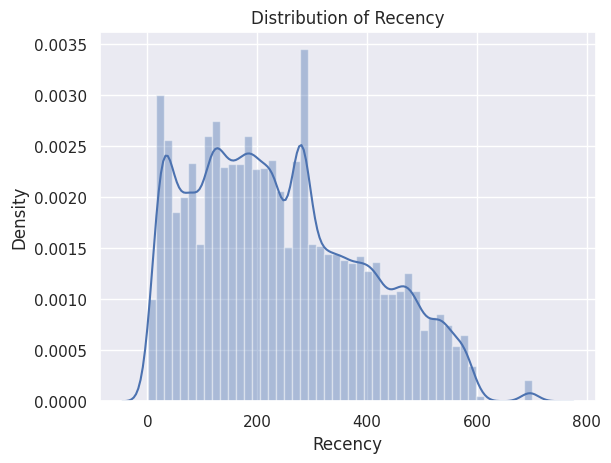

Recency's: Skew: 0.4525743664936904, : SkewtestResult(statistic=53.91755466635981, pvalue=0.0)


<ipython-input-57-31a94896c4d8>:5: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




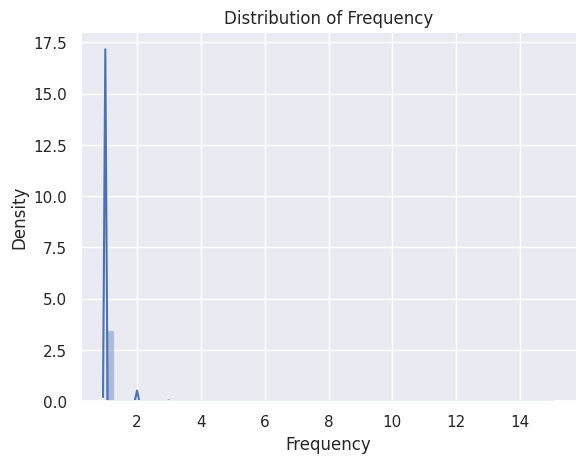

Frequency's: Skew: 10.990942154921314, : SkewtestResult(statistic=335.6456861541721, pvalue=0.0)


<ipython-input-57-31a94896c4d8>:5: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




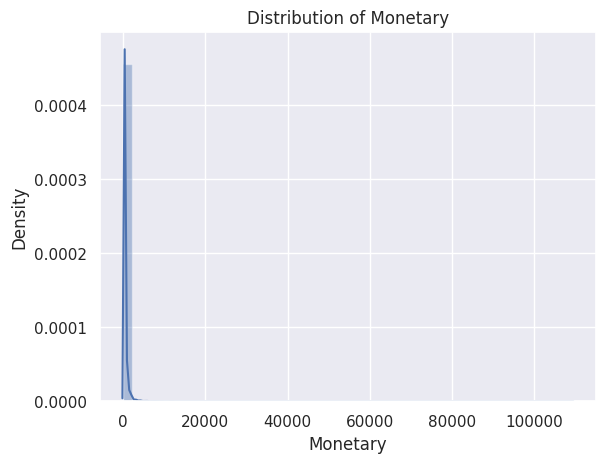

Monetary's: Skew: 70.33621193560055, : SkewtestResult(statistic=524.6379205104615, pvalue=0.0)


In [ ]:
for col in rfm.columns[1:]:
    check_skew(rfm, col)

In [ ]:
rfm_log = rfm.copy()
for c in rfm.columns[1:]:
    rfm_log[c] = np.log10(rfm_log[c])

<ipython-input-57-31a94896c4d8>:5: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




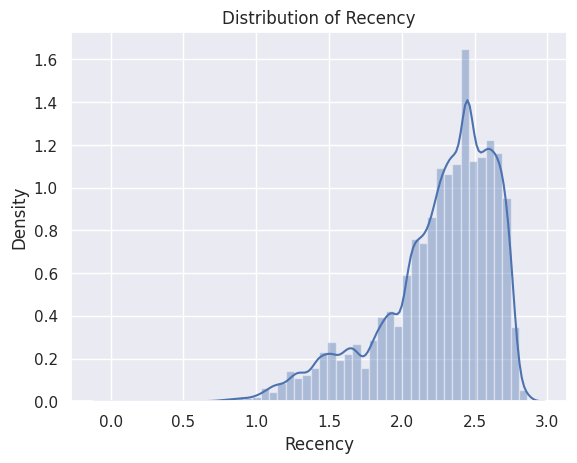

Recency's: Skew: -1.0782500114150588, : SkewtestResult(statistic=-111.14545442314179, pvalue=0.0)


<ipython-input-57-31a94896c4d8>:5: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




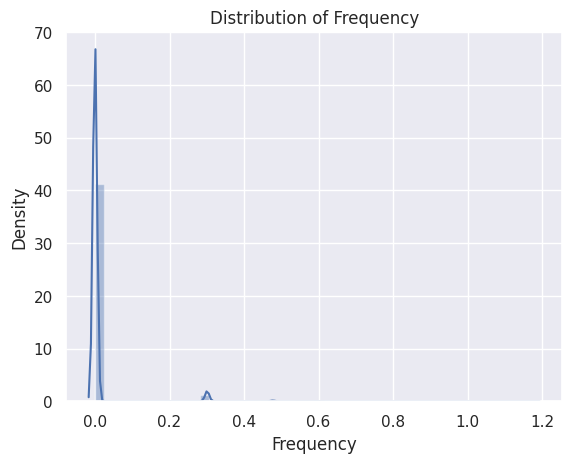

Frequency's: Skew: 6.068294981630156, : SkewtestResult(statistic=275.4417097222108, pvalue=0.0)


<ipython-input-57-31a94896c4d8>:5: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




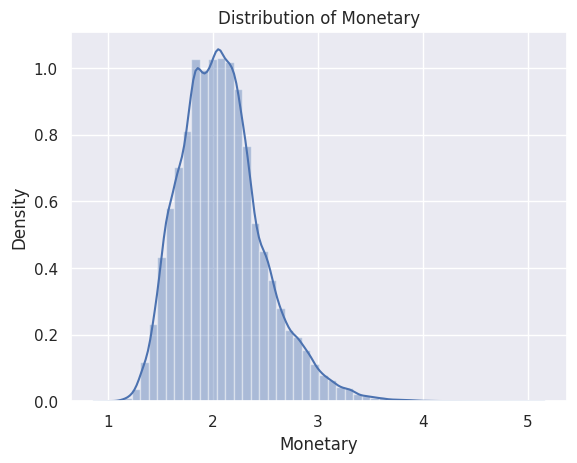

Monetary's: Skew: 0.729609897634013, : SkewtestResult(statistic=81.9204555191681, pvalue=0.0)


In [ ]:
for col in rfm.columns[1:]:
    check_skew(rfm_log, col)

In [ ]:
rfm_log

,customer_unique_id,Recency,Frequency,Monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,2.064458,0.0,2.151982
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2.075547,0.0,1.434409
2,0000f46a3911fa3c0805444483337064,2.733999,0.0,1.935608
3,0000f6ccb0745a6a4b88665a16c9f078,2.513218,0.0,1.639686
4,0004aac84e0df4da2b147fca70cf8255,2.466868,0.0,2.294224
...,...,...,...,...
93391,fffcf5a5ff07b0908bd4e2dbc735a684,2.655138,0.0,3.616459
93392,fffea47cd6d3cc0a88bd621562a9d061,2.426511,0.0,1.927268
93393,ffff371b4d645b6ecea244b27531430a,2.758155,0.0,2.050998
93394,ffff5962728ec6157033ef9805bacc48,2.093422,0.0,2.126099


In [ ]:
rfm_log.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 93396 entries, 0 to 93395
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   customer_unique_id  93396 non-null  object 
 1   Recency             93396 non-null  float64
 2   Frequency           93396 non-null  float64
 3   Monetary            93396 non-null  float64
dtypes: float64(3), object(1)
memory usage: 3.6+ MB


In [ ]:
def pipe(X):
  X_num_col = X.select_dtypes(include = ([np.number])).columns.values
  X_num_cat = X.select_dtypes(include = (['object'])).columns.values

  cat_cols = X_num_cat
  cont_cols = X_num_col

  full_pipe = ColumnTransformer(transformers = [('onehot_enc', OneHotEncoder(), cat_cols), ('std_scl', StandardScaler(), cont_cols)],
                                remainder = 'passthrough')

  X_pipe = full_pipe.fit_transform(X)

  return X_pipe

In [ ]:
rfm_done = pipe(rfm_log)

## 5. Data Modelling (Clustering)

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



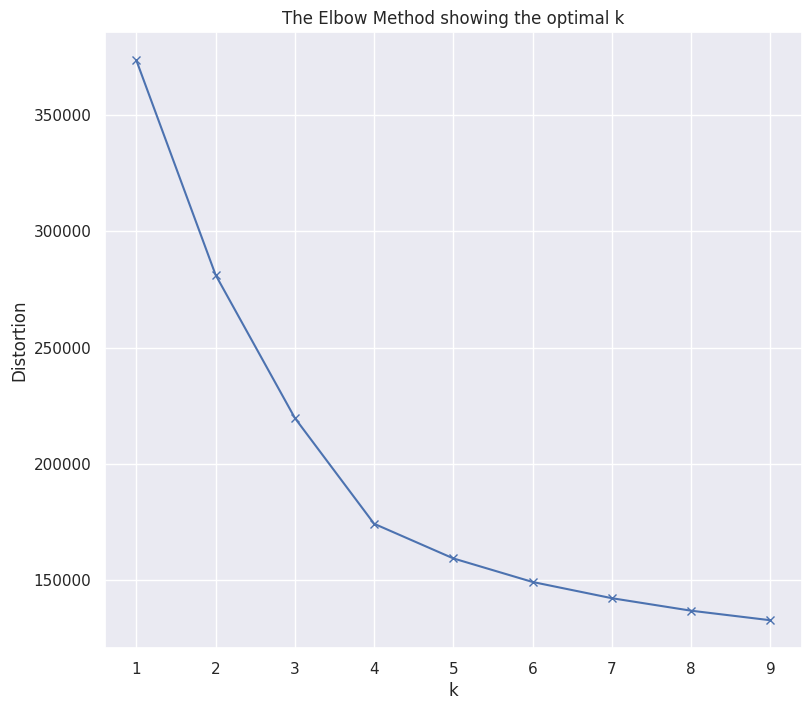

In [ ]:
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(rfm_done)
    distortions.append(kmeanModel.inertia_)

plt.figure(figsize=(9,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [ ]:
kmean_model = KMeans(n_clusters = 4, random_state = 10)
kmean_y = kmean_model.fit_predict(rfm_done)

In [ ]:
def rfm_values(df):
    df_new = df.groupby(['Cluster']).agg({
            'Recency': 'mean',
            'Frequency': 'mean',
            'Monetary': ['mean', 'count']
        }).round(0)

    return df_new

In [ ]:
rfm['Cluster'] = kmean_model.labels_

In [ ]:
rfm

,customer_unique_id,Recency,Frequency,Monetary,Cluster
0,0000366f3b9a7992bf8c76cfdf3221e2,116,1,141.90,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,119,1,27.19,0
2,0000f46a3911fa3c0805444483337064,542,1,86.22,0
3,0000f6ccb0745a6a4b88665a16c9f078,326,1,43.62,0
4,0004aac84e0df4da2b147fca70cf8255,293,1,196.89,2
...,...,...,...,...,...
93391,fffcf5a5ff07b0908bd4e2dbc735a684,452,1,4134.84,2
93392,fffea47cd6d3cc0a88bd621562a9d061,267,1,84.58,0
93393,ffff371b4d645b6ecea244b27531430a,573,1,112.46,0
93394,ffff5962728ec6157033ef9805bacc48,124,1,133.69,0


In [ ]:
#rfm.to_csv('engage.csv')

In [ ]:
rfm_values(rfm)

Recency Frequency Monetary       
           mean      mean     mean  count
Cluster                                  
0         298.0       1.0     77.0  45578
1          51.0       1.0    144.0  17574
2         275.0       1.0    457.0  27437
3         226.0       2.0    488.0   2807

### RFM Analysis


##### RFM stands for recency, frequency, monetary value. In business analytics, we often use this concept to divide customers into different segments, like high-value customers, medium value customers or low-value customers, and similarly many others.

##### Recency: How recently has the customer made a transaction with the company until end of session.

##### Frequency: How frequent is the customer in ordering/buying some product from the company

##### Monetary: How much does the customer spend on purchasing products from the company.


### Cluster Analysis

#### Cluster 0 : These are Low spenders in this cluster. Customers in this cluster seem have one of the highest recency and their monetary value is low. This cluster shouldn't be the focus of marketing effort.

#### Cluster 1 : These are the  New Comers in this cluster as their spending is the smallest among all clusters but have the lowest recency. This cluster is quite huge. So, some marketing effort could be advisable towards it in order to increase its monetary value.

#### Cluster 2 : These are the Big spenders cluster as it's recency comes second and the average amount spent is largest. This cluster is also second in terms of number of customers.

#### Cluster 3 : These are  the Loyal customers in this cluster haven't on average ordered in a while, their frequency of orders is greater than all other clusters and the value of their orders is quite high.


## 6. Feature Engineering 2

In [ ]:
rfm

,customer_unique_id,Recency,Frequency,Monetary,Cluster
0,0000366f3b9a7992bf8c76cfdf3221e2,116,1,141.90,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,119,1,27.19,0
2,0000f46a3911fa3c0805444483337064,542,1,86.22,0
3,0000f6ccb0745a6a4b88665a16c9f078,326,1,43.62,0
4,0004aac84e0df4da2b147fca70cf8255,293,1,196.89,2
...,...,...,...,...,...
93391,fffcf5a5ff07b0908bd4e2dbc735a684,452,1,4134.84,2
93392,fffea47cd6d3cc0a88bd621562a9d061,267,1,84.58,0
93393,ffff371b4d645b6ecea244b27531430a,573,1,112.46,0
93394,ffff5962728ec6157033ef9805bacc48,124,1,133.69,0


In [ ]:
rfm.shape, rfm.columns

((93396, 5),
 Index(['customer_unique_id', 'Recency', 'Frequency', 'Monetary', 'Cluster'], dtype='object'))

In [ ]:
cont_columns = list(rfm.select_dtypes(include=[np.number]).columns.values)
cont_columns

['Recency', 'Frequency', 'Monetary', 'Cluster']

In [ ]:
fig = px.pie(rfm['Cluster'], names = rfm['Cluster'].value_counts().index,
             values = rfm['Cluster'].value_counts().values,
             title = 'Cluster Percentage')
fig.show()

**1. Plot for Recency**

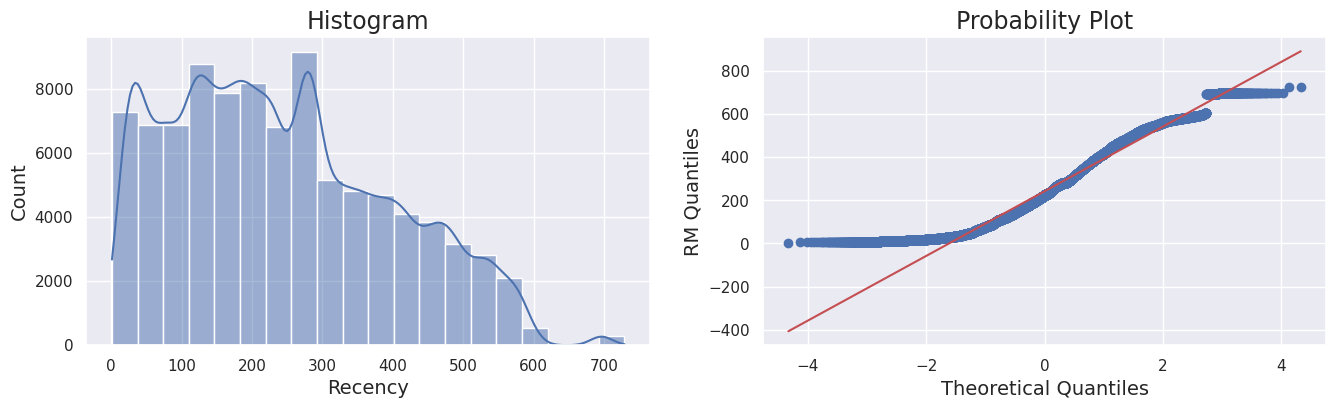

**2. Plot for Frequency**

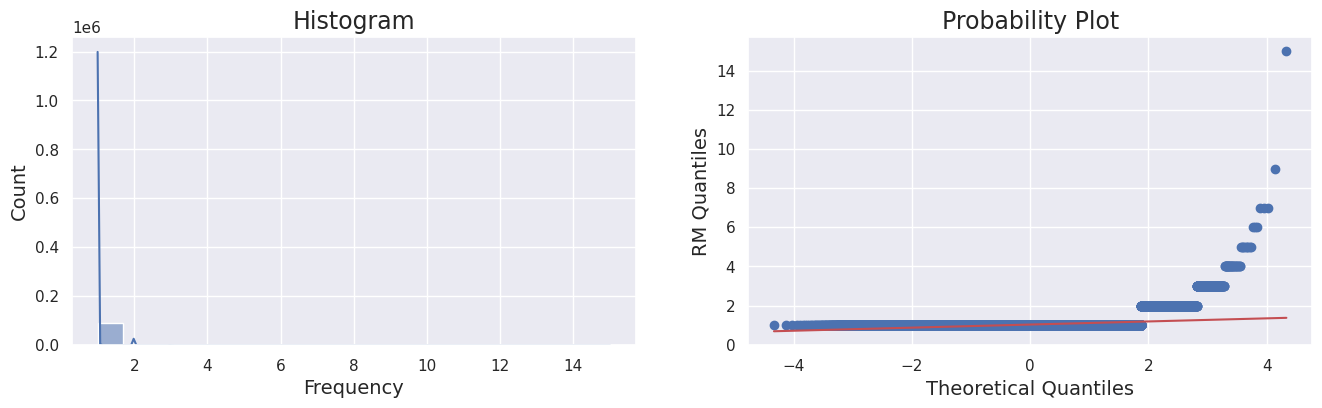

**3. Plot for Monetary**

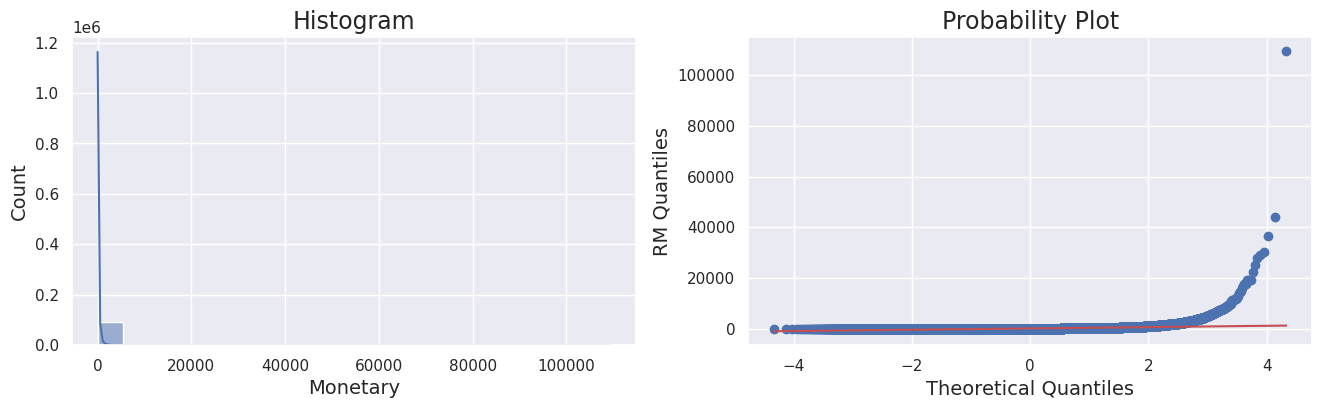

**4. Plot for Cluster**

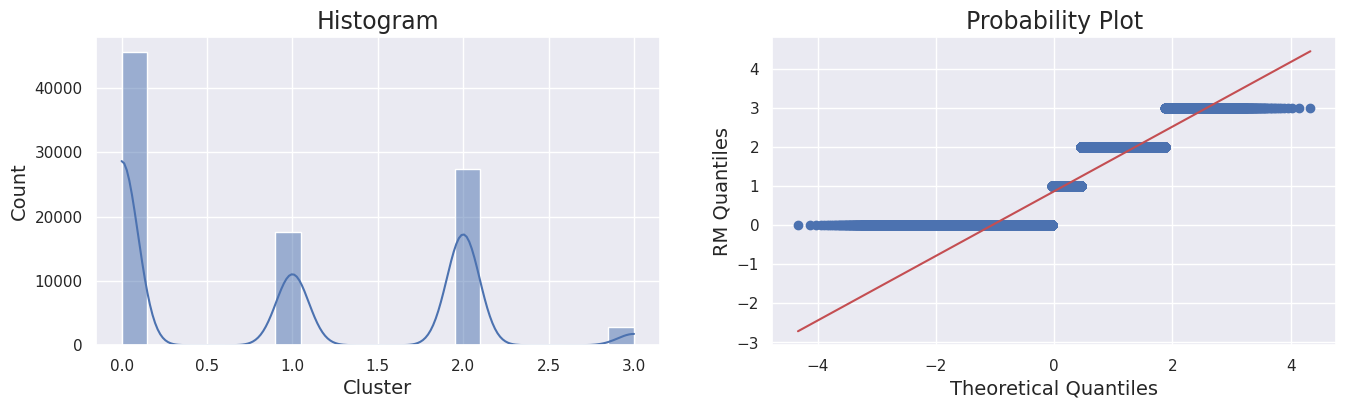

In [ ]:
eda.numerical_plots(rfm, cont_columns, normality_check = True)

<ipython-input-57-31a94896c4d8>:5: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




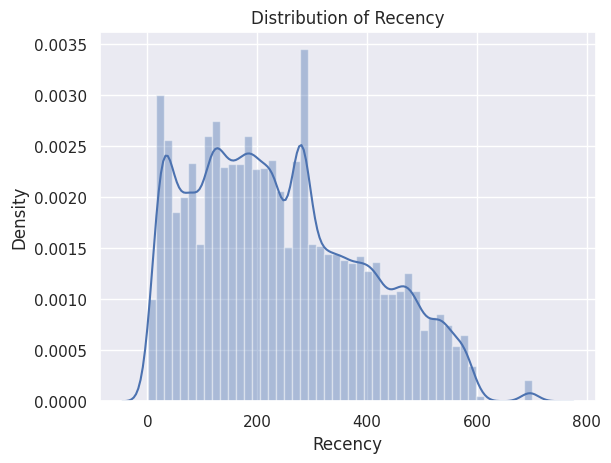

Recency's: Skew: 0.4525743664936904, : SkewtestResult(statistic=53.91755466635981, pvalue=0.0)


<ipython-input-57-31a94896c4d8>:5: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




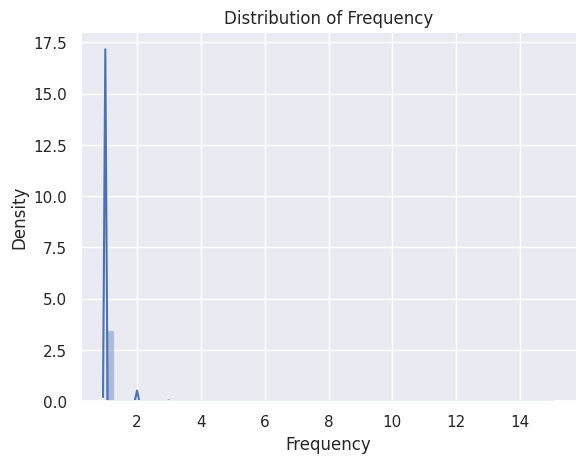

Frequency's: Skew: 10.990942154921314, : SkewtestResult(statistic=335.6456861541721, pvalue=0.0)


<ipython-input-57-31a94896c4d8>:5: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




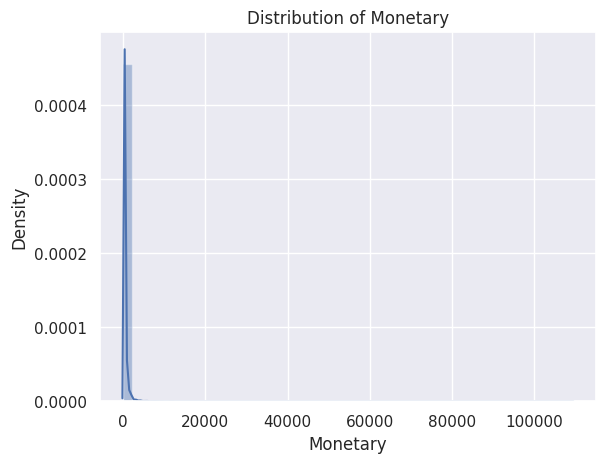

Monetary's: Skew: 70.33621193560055, : SkewtestResult(statistic=524.6379205104615, pvalue=0.0)


In [ ]:
for col in rfm.columns[1:4]:
    check_skew(rfm, col)

In [ ]:
rfm_log_new = rfm.copy()
for c in rfm.columns[1:4]:
    rfm_log_new[c] = np.log10(rfm_log_new[c])

<ipython-input-57-31a94896c4d8>:5: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




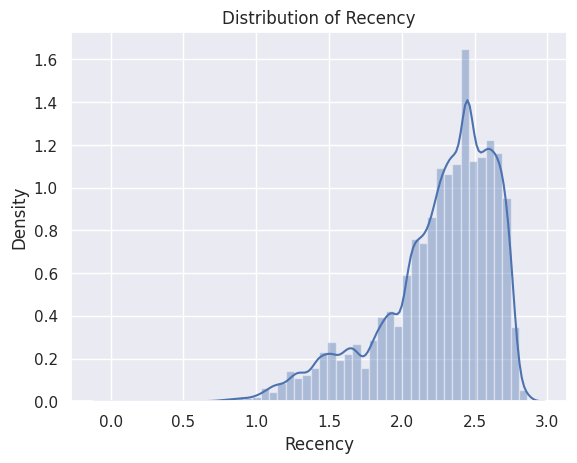

Recency's: Skew: -1.0782500114150588, : SkewtestResult(statistic=-111.14545442314179, pvalue=0.0)


<ipython-input-57-31a94896c4d8>:5: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




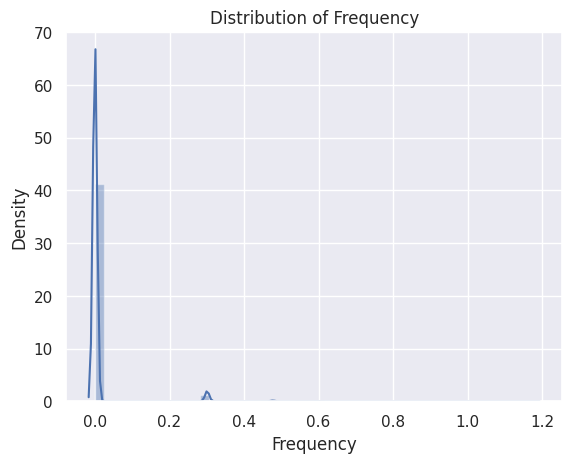

Frequency's: Skew: 6.068294981630156, : SkewtestResult(statistic=275.4417097222108, pvalue=0.0)


<ipython-input-57-31a94896c4d8>:5: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




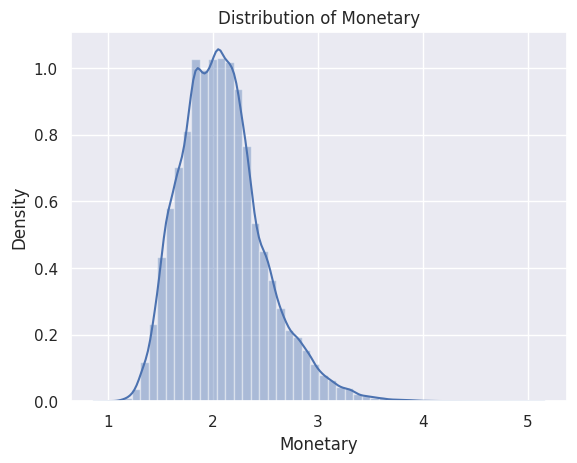

Monetary's: Skew: 0.729609897634013, : SkewtestResult(statistic=81.9204555191681, pvalue=0.0)


In [ ]:
for col in rfm.columns[1:4]:
    check_skew(rfm_log_new, col)

In [ ]:
rfm_log_new

,customer_unique_id,Recency,Frequency,Monetary,Cluster
0,0000366f3b9a7992bf8c76cfdf3221e2,2.064458,0.0,2.151982,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2.075547,0.0,1.434409,0
2,0000f46a3911fa3c0805444483337064,2.733999,0.0,1.935608,0
3,0000f6ccb0745a6a4b88665a16c9f078,2.513218,0.0,1.639686,0
4,0004aac84e0df4da2b147fca70cf8255,2.466868,0.0,2.294224,2
...,...,...,...,...,...
93391,fffcf5a5ff07b0908bd4e2dbc735a684,2.655138,0.0,3.616459,2
93392,fffea47cd6d3cc0a88bd621562a9d061,2.426511,0.0,1.927268,0
93393,ffff371b4d645b6ecea244b27531430a,2.758155,0.0,2.050998,0
93394,ffff5962728ec6157033ef9805bacc48,2.093422,0.0,2.126099,0


In [ ]:
eda.numerical_check_outliers(rfm_log_new, list(rfm_log_new.select_dtypes(include=[np.number]).columns.values), tol=1.5, print_vars = False)

,lower_bound_outliers,upper_bound_outliers,total_outliers,perc_outliers
Recency,3369,0,3369,3.607221
Frequency,0,2807,2807,3.005482
Monetary,3,1840,1843,1.973318
Cluster,0,0,0,0.000000


In [ ]:
outliers = eda.numerical_check_outliers(rfm_log_new, list(rfm_log_new.select_dtypes(include=[np.number]).columns.values), tol=1.5, print_vars = False)
per = outliers['perc_outliers']
tot = outliers['total_outliers']

In [ ]:
fig = px.bar(per, x = per.index, y = per.values, title = "Outliers on Basis of Percentage")
fig.show()

In [ ]:
fig = px.bar(tot, x = tot.index, y = tot.values, title = "Outliers on Basis of Count")
fig.show()

In [ ]:
elpenv = EllipticEnvelope(contamination=0.025, random_state=1)
  # Returns 1 of inliers, -1 for outliers
pred = elpenv.fit_predict(rfm_log_new[list(rfm_log_new.select_dtypes(include=[np.number]).columns.values)])

anom_index = np.where(pred==-1)
rem = rfm_log_new.loc[anom_index]

rem


,customer_unique_id,Recency,Frequency,Monetary,Cluster
120,004b45ec5c64187465168251cd1c9c2f,2.000000,0.301030,2.169439,3
140,0058f300f57d7b93c477a131a59b36c3,2.217484,0.301030,2.244475,3
243,00a39521eb40f7012db50455bf083460,1.963788,0.301030,2.090787,3
305,00cc12a6d8b578b8ebd21ea4e2ae8b27,2.725095,0.301030,2.402089,3
404,011575986092c30523ecb71ff10cb473,2.139879,0.301030,2.332236,3
...,...,...,...,...,...
93071,ff22e30958c13ffe219db7d711e8f564,0.000000,0.301030,2.522340,3
93123,ff44401d0d8f5b9c54a47374eb48c1b8,2.673942,0.301030,1.832509,3
93228,ff8892f7c26aa0446da53d01b18df463,2.448706,0.301030,2.598659,3
93244,ff922bdd6bafcdf99cb90d7f39cea5b3,2.549003,0.477121,2.144885,3


In [ ]:
rfm_log_new.drop(index = rem.index, axis = 0, inplace = True)

In [ ]:
rfm_log_new.shape

(91061, 5)

In [ ]:
X = rfm_log_new.drop('Cluster', axis = 1)
y = rfm_log_new['Cluster']

In [ ]:
type(X), type(y)

(pandas.core.frame.DataFrame, pandas.core.series.Series)

In [ ]:
c

'Monetary'

In [ ]:
X.head(10)

,customer_unique_id,Recency,Frequency,Monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,2.064458,0.0,2.151982
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2.075547,0.0,1.434409
2,0000f46a3911fa3c0805444483337064,2.733999,0.0,1.935608
3,0000f6ccb0745a6a4b88665a16c9f078,2.513218,0.0,1.639686
4,0004aac84e0df4da2b147fca70cf8255,2.466868,0.0,2.294224
5,0004bd2a26a76fe21f786e4fbd80607f,2.178977,0.0,2.222664
6,00050ab1314c0e55a6ca13cf7181fecf,2.133539,0.0,1.548758
7,00053a61a98854899e70ed204dd4bafe,2.271842,0.0,2.923431
8,0005e1862207bf6ccc02e4228effd9a0,2.738781,0.0,2.176439
9,0005ef4cd20d2893f0d9fbd94d3c0d97,2.243038,0.0,2.113141


In [ ]:
y.head(10)

0    1
1    0
2    0
3    0
4    2
5    2
6    0
7    2
8    0
9    0
Name: Cluster, dtype: int32

In [ ]:
X.dtypes

customer_unique_id     object
Recency               float64
Frequency             float64
Monetary              float64
dtype: object

In [ ]:
X_cols = X.select_dtypes(include = ([np.number])).columns.values
X_cats = X.select_dtypes(include = (['object'])).columns.values

In [ ]:
X_cols, X_cats

(array(['Recency', 'Frequency', 'Monetary'], dtype=object),
 array(['customer_unique_id'], dtype=object))

In [ ]:
full_pipe = ColumnTransformer(transformers = [('ord_enc', OrdinalEncoder(), X_cats), ('std_scl', StandardScaler(), X_cols)],
                                remainder = 'passthrough')

X_pipe = full_pipe.fit_transform(X)

X_pipe

array([[ 0.00000000e+00, -5.05150655e-01, -7.22595470e-02,
         1.89307431e-01],
       [ 1.00000000e+00, -4.76302196e-01, -7.22595470e-02,
        -1.63107491e+00],
       [ 2.00000000e+00,  1.23669108e+00, -7.22595470e-02,
        -3.59603956e-01],
       ...,
       [ 9.10580000e+04,  1.29953227e+00, -7.22595470e-02,
        -6.68755882e-02],
       [ 9.10590000e+04, -4.29800300e-01, -7.22595470e-02,
         1.23644699e-01],
       [ 9.10600000e+04,  1.12042693e+00, -7.22595470e-02,
        -5.64931493e-01]])

In [ ]:
X_rfm =  X_pipe
X_rfm

array([[ 0.00000000e+00, -5.05150655e-01, -7.22595470e-02,
         1.89307431e-01],
       [ 1.00000000e+00, -4.76302196e-01, -7.22595470e-02,
        -1.63107491e+00],
       [ 2.00000000e+00,  1.23669108e+00, -7.22595470e-02,
        -3.59603956e-01],
       ...,
       [ 9.10580000e+04,  1.29953227e+00, -7.22595470e-02,
        -6.68755882e-02],
       [ 9.10590000e+04, -4.29800300e-01, -7.22595470e-02,
         1.23644699e-01],
       [ 9.10600000e+04,  1.12042693e+00, -7.22595470e-02,
        -5.64931493e-01]])

In [ ]:
X_rfm.shape, y.shape

((91061, 4), (91061,))

In [ ]:
sm = SMOTE()
X_sm, y_sm = sm.fit_resample(X_rfm, y)

In [ ]:
fig = px.pie(y, names = y.value_counts().index,
             values = y.value_counts().values,
             title = 'Before SMOTE Process')
fig.show()

In [ ]:
fig = px.pie(y_sm, names = y_sm.value_counts().index,
             values = y_sm.value_counts().values,
             title = 'After SMOTE Process')
fig.show()

In [ ]:
X_sm.shape, y_sm.shape

((182312, 4), (182312,))

In [ ]:
X_train, X_test, y_train , y_test = tts(X_sm, y_sm, test_size= .33, random_state = 10)

In [ ]:
# X_train, X_test, y_train, y_test = evalml.preprocessing.split_data(X_sm, y_sm, test_size = .33,
#                                                                    problem_type = 'Multiclass')

In [ ]:
X_train.shape, y_train.shape

((122149, 4), (122149,))

In [ ]:
X_test.shape, y_test.shape

((60163, 4), (60163,))

## 7. Data Modeling (Classification)

In [ ]:
model_rfc=RandomForestClassifier(n_jobs= -1, max_depth = 5, min_samples_split= 5,
                                 random_state= 10, n_estimators= 200)

model_rfc.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, min_samples_split=5, n_estimators=200,
                       n_jobs=-1, random_state=10)

In [ ]:
y_pred_rfc = model_rfc.predict(X_test)

In [ ]:
train_acc_rfc = model_rfc.score(X_train, y_train)
print("The Accuracy for Training Set is {}".format(train_acc_rfc*100))

The Accuracy for Training Set is 99.0257799900122


In [ ]:
test_acc_rfc = accuracy_score(y_test, y_pred_rfc)
print("The Accuracy for Test Set is {}".format(test_acc_rfc*100))

The Accuracy for Test Set is 99.02265512025663


In [ ]:
print(classification_report(y_test, y_pred_rfc))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99     15004
           1       0.98      0.99      0.99     15168
           2       0.99      0.98      0.99     14950
           3       1.00      1.00      1.00     15041

    accuracy                           0.99     60163
   macro avg       0.99      0.99      0.99     60163
weighted avg       0.99      0.99      0.99     60163



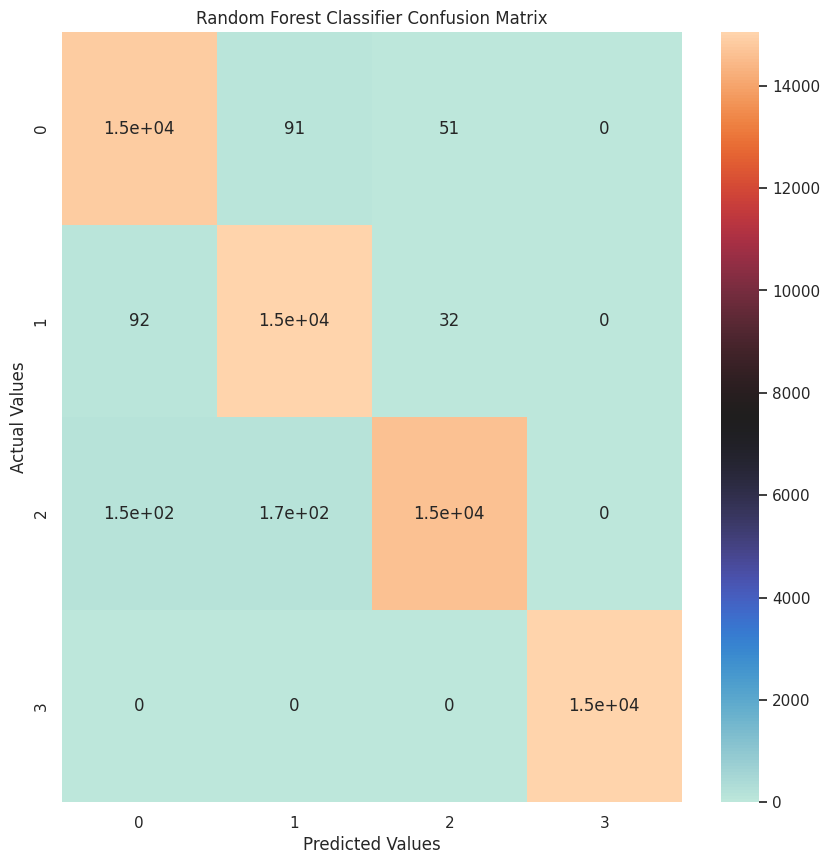

In [ ]:
plt.figure(figsize=(10,10))
plt.title("Random Forest Classifier Confusion Matrix")
sns.heatmap(confusion_matrix(y_test,y_pred_rfc), annot = True, cmap ='icefire')
plt.ylabel("Actual Values")
plt.xlabel("Predicted Values")
plt.show()

In [ ]:
input_data = [('0000366f3b9a7992bf8c76cfdf3221e2',	116,	1,	141.90)]

In [ ]:
ex = pd.DataFrame(input_data, columns = ['customer_unique_id', 'Recency', 'Frequency', 'Monetary'])
ex

,customer_unique_id,Recency,Frequency,Monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,116,1,141.9


In [ ]:
for c in ex.columns[1:4]:
    ex[c] = np.log10(ex[c])

ex

,customer_unique_id,Recency,Frequency,Monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,2.064458,0.0,2.151982


In [ ]:
scale_ex = full_pipe.transform(ex)

In [ ]:
prdctn = model_rfc.predict(scale_ex)
prdctn

array([0], dtype=int32)

In [ ]:
input_data = [('0000b849f77a49e4a4ce2b2a4ca5be3f', 119, 1, 27.19)]

In [ ]:
ex = pd.DataFrame(input_data, columns = ['customer_unique_id', 'Recency', 'Frequency', 'Monetary'])
ex

,customer_unique_id,Recency,Frequency,Monetary
0,0000b849f77a49e4a4ce2b2a4ca5be3f,119,1,27.19


In [ ]:
for c in ex.columns[1:4]:
    ex[c] = np.log10(ex[c])

ex

,customer_unique_id,Recency,Frequency,Monetary
0,0000b849f77a49e4a4ce2b2a4ca5be3f,2.075547,0.0,1.434409


In [ ]:
scale_ex = full_pipe.transform(ex)

In [ ]:
prdctn = model_rfc.predict(scale_ex)
prdctn

array([0], dtype=int32)

In [ ]:
input_data = [('0000b849f77a49e4a4ce2b2a4ca5be3f', 233, 2, 765)]

In [ ]:
ex = pd.DataFrame(input_data, columns = ['customer_unique_id', 'Recency', 'Frequency', 'Monetary'])
ex

,customer_unique_id,Recency,Frequency,Monetary
0,0000b849f77a49e4a4ce2b2a4ca5be3f,233,2,765


In [ ]:
for c in ex.columns[1:4]:
    ex[c] = np.log10(ex[c])

ex

,customer_unique_id,Recency,Frequency,Monetary
0,0000b849f77a49e4a4ce2b2a4ca5be3f,2.367356,0.30103,2.883661


In [ ]:
scale_ex = full_pipe.transform(ex)

In [ ]:
prdctn = model_rfc.predict(scale_ex)
prdctn

array([3], dtype=int32)

In [ ]:
input_data = [('0000366f3b9a7992bf8c76cfdf3221e2',	236,	1,	1141.90)]

In [ ]:
ex = pd.DataFrame(input_data, columns = ['customer_unique_id', 'Recency', 'Frequency', 'Monetary'])
ex

,customer_unique_id,Recency,Frequency,Monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,236,1,1141.9


In [ ]:
for c in ex.columns[1:4]:
    ex[c] = np.log10(ex[c])

ex

,customer_unique_id,Recency,Frequency,Monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,2.372912,0.0,3.057628


In [ ]:
scale_ex = full_pipe.transform(ex)

In [ ]:
prdctn = model_rfc.predict(scale_ex)
prdctn

array([2], dtype=int32)

## 8. Save Model

In [ ]:
filename = 'prop_engage_model.p'

In [ ]:
pickle.dump(model_rfc, open(filename, 'wb'))

## 9. Deployment
#####Note: Deployment should be done on local machine but for development processes it is done here.

In [ ]:
%%writefile app.py

import numpy as np
import pandas as pd
import streamlit as st
import pickle

pickle_in = open('prop_engage_model.p', "rb")
model = pickle.load(pickle_in)

def welcome():
    return "Hello! Welcome to Upstore!"


def predict_op(customer_unique_id, Recency, Frequency, Monetary):


    customer_unique_id = float(customer_unique_id)
    Recency = np.log10(float(Recency))
    Frequency = np.log10(float(Frequency))
    Monetary = np.log10(float(Monetary))

    prediction = model.predict([[customer_unique_id, Recency, Frequency, Monetary]])
    print(prediction)
    return prediction

def main():
    st.title("Welcome to Upstore")
    st.text("Let's Find out the Propensity to Engage for a particular customer.")
    st.text("Here the model will predict the market segment of a particular customer.")
    st.text("So, 0: low spender, 1: new comer, 2: big spender, 3: loyal customer")
    html_temp = """
    <div style="background-color:tomato;padding:10px">
    <h2 style="color:white;text-align:center;">Propensity to Engage App </h2>
    </div>
    """
    st.markdown(html_temp,  unsafe_allow_html=True)
    customer_unique_id = st.text_input("Customer ID:")
    Recency = st.text_input("Recency Value:")
    Frequency = st.text_input("Frequency Value:")
    Monetary = st.text_input("Monetary Value:")

    result=""
    if st.button("Predict"):
        result=predict_op(customer_unique_id, Recency, Frequency, Monetary)
    st.success('The market segment of this customer is {}'.format(result))
    if st.button("About"):
        st.text("Made with love by the students of NMIMS Indore <3")


if __name__ == '__main__':
  main()

Writing app.py


In [ ]:
!ls

app.py				  olist_products_dataset.csv
olist_customers_dataset.csv	  olist_sellers_dataset.csv
olist_order_items_dataset.csv	  product_category_name_translation.csv
olist_order_payments_dataset.csv  prop_engage_model.p
olist_order_reviews_dataset.csv   sample_data
olist_orders_dataset.csv


In [ ]:
!streamlit run app.py & npx localtunnel --port 8501

[#######...........] / extract:localtunnel: verb lock using /root/.npm/_locks/s


  You can now view your Streamlit app in your browser.

  Network URL: http://172.28.0.12:8501
  External URL: http://35.237.37.152:8501

npx: installed 22 in 3.484s
your url is: https://quiet-emus-knock-35-237-37-152.loca.lt
  Stopping...
^C
